##Mô tả dữ liệu ##

| 🏷️ **Tên cột**           | 🔢 **Kiểu dữ liệu** |       🌍 **Phạm vi / Giá trị**       | 🧠 **Ý nghĩa & Vai trò**                                                                           | ⚙️ **Xử lý / Encoder**                                                                  |   |                                                            |
| :------------------------ | :-----------------: | :----------------------------------: | :------------------------------------------------------------------------------------------------- | :-------------------------------------------------------------------------------------- | - | ---------------------------------------------------------- |
| **Trip_Distance_km**      |        Float        |             0 → ~140 (km)            | Tổng quãng đường di chuyển của chuyến taxi (km). Biến **liên tục** có ảnh hưởng trực tiếp đến giá. | **Numeric**, xử lý **outlier bằng IQR**, chuẩn hóa bằng **StandardScaler**              |   |                                                            |
| **Time_of_Day**           |  String / Category  | {Morning, Afternoon, Evening, Night} | Thời điểm trong ngày khi chuyến đi bắt đầu. Phản ánh lưu lượng giao thông và nhu cầu di chuyển.    | **Categorical**, mã hóa **OneHotEncoder**                                               |   |                                                            |
| **Day_of_Week**           |  String / Category  |          {Weekday, Weekend}          | Loại ngày: ngày thường hoặc cuối tuần. Cuối tuần giá thường cao hơn.                               | **Categorical**, mã hóa **OneHotEncoder**                                               |   |                                                            |
| **Passenger_Count**       |       Integer       |                 1 → 6                | Số hành khách đi trên chuyến taxi. Ảnh hưởng đến loại xe & chi phí.                                | **Numeric**, Z-score (ABS(Z) >3) để phát hiện ngoại lai, chuẩn hóa **StandardScaler** |
| **Traffic_Conditions**    |  String / Category  |          {Low, Medium, High}         | Mức độ tắc nghẽn giao thông tại thời điểm chuyến đi.                                               | **Categorical có thứ tự (Ordinal)**, dùng **LabelEncoder** (Low=0, Medium=1, High=2)    |   |                                                            |
| **Weather**               |  String / Category  |           {Clear, Rain,Snow}           | Điều kiện thời tiết trong chuyến đi (trời trong, mưa,…). Ảnh hưởng đến thời gian và giá.           | **Categorical**, điền thiếu bằng **Constant = 'Clear'**, mã hóa **OneHotEncoder**       |   |                                                            |
| **Base_Fare**             |        Float        |                  ≥ 0                 | Phí mở cửa của chuyến taxi.                                                                        | **Numeric**, Z-score  (ABS(Z) >3) cắt ngoại lai, chuẩn hóa **StandardScaler**          |
| **Per_Km_Rate**           |        Float        |                  ≥ 0                 | Mức giá cước theo quãng đường (đơn vị/km).                                                         | **Numeric**, Z-score (ABS(Z) >3) cắt ngoại lai, chuẩn hóa **StandardScaler**          |
| **Per_Minute_Rate**       |        Float        |                  ≥ 0                 | Mức giá cước theo thời gian di chuyển (đơn vị/phút).                                               | **Numeric**, Z-score (ABS(Z) >3) cắt ngoại lai, chuẩn hóa **StandardScaler**          |
| **Trip_Duration_Minutes** |        Float        |            0 → ~120 (phút)           | Tổng thời gian chuyến đi. Phụ thuộc vào quãng đường, giao thông và thời tiết.                      | **Numeric**, **IQR** để phát hiện ngoại lai (log1p scale), chuẩn hóa **StandardScaler** |   |                                                            |
| **Trip_Price**            |        Float        |           ≥ 0 (đơn vị tiền)          | Giá cước thực tế của chuyến taxi – **biến mục tiêu (Target)** cần dự đoán.                         | –                                                                                       |   |                                                            |


##Một số bước cần xử lí(Ước chừng trước) ##

| Cột                   | Kiểu    | Thiếu dữ liệu        | Miền giá trị (áp trước) | Outlier (phát hiện → xử lý)                                                                | Chuẩn hoá      |                           |                |
| --------------------- | ------- | -------------------- | ----------------------- | ------------------------------------------------------------------------------------------ | -------------- | ------------------------- | -------------- |
| Trip_Distance_km      | Numeric | Drop nếu NaN         | ≥ 0                     | IQR trên log1p → cap về [Q1−1.5·IQR, Q3+1.5·IQR]; nếu **speed** vẫn bất hợp lý ⇒ drop dòng | StandardScaler |                           |                |
| Trip_Duration_Minutes | Numeric | Drop nếu NaN         | ≥ 0                     | IQR trên log1p + **rule speed**: distance/(duration/60) ∈ [1, 130]; vi phạm ⇒ drop         | StandardScaler |                           |                |
| Passenger_Count       | Numeric | Median               | Clamp về [1, 6]         | Z-score (ABS(Z) >3) → cap về mean ± 3·std | StandardScaler |
| Base_Fare             | Numeric | Mean                 | ≥ 0                     | Z-score (ABS(Z) >3) → cap                 | StandardScaler |
| Per_Km_Rate           | Numeric | Mean                 | ≥ 0                     | Z-score (ABS(Z) >3) → cap                 | StandardScaler |
| Per_Minute_Rate       | Numeric | Mean                 | ≥ 0                     | Z-score (ABS(Z) >3) → cap                 | StandardScaler |
| Trip_Price (target)   | Target  | Drop nếu NaN (train) | ≥ 0                     | Không áp dụng                                                                              |             |                           |                |


| Cột                | Kiểu        | Thiếu dữ liệu      | Miền giá trị (chuẩn hoá)             | Phát hiện & xử lý giá trị không nhất quán                                                                           | Mã hoá                               |
| ------------------ | ----------- | ------------------ | ------------------------------------ | ------------------------------------------------------------------------------------------------------------------- | ------------------------------------ |
| Time_of_Day        | Categorical | Mode               | {morning, afternoon, evening, night} | lower() + strip(); sửa lỗi chính tả: {'moring'→'morning','afternon'→'afternoon'}; nếu có AM/PM → map nhóm tương ứng | OneHotEncoder                        |
| Day_of_Week        | Categorical | Mode               | {weekday, weekend}                   | lower() + strip(); mapping: {'week day','weekdays'→'weekday'}                                                       | OneHotEncoder                        |
| Weather            | Categorical | Constant = 'clear' | {clear, rain, cloudy, stormy,…}      | lower() + strip(); gom nhóm: {'rainy','stormy'→'rain'}; mapping: {'clear '→'clear'}                                 | OneHotEncoder                        |
| Traffic_Conditions | Ordinal     | Mode               | {low, medium, high}                  | lower() + strip(); đồng nhất: {'mid','normal'→'medium','hi'→'high'}                                                 | Label/Ordinal (low=0, med=1, high=2) |


##Một số feature mới có thể mở rộng để xử lí thêm EDA ##

| Feature mới         | Công thức / Ý nghĩa                                                           | Dạng dữ liệu | Vai trò                                                               |
| ------------------- | ----------------------------------------------------------------------------- | ------------ | --------------------------------------------------------------------- |
| **Speed_kmh**       | `Trip_Distance_km / (Trip_Duration_Minutes / 60)` → Tốc độ trung bình (km/h). | Float        | Giúp phát hiện outlier và đặc trưng hoá điều kiện giao thông thực tế. |
| **Duration_per_km** | `Trip_Duration_Minutes / Trip_Distance_km`                                    | Float        | Phản ánh độ chậm của tuyến đường, ảnh hưởng bởi tắc nghẽn.            |
| **Expected_Fare**   | `Base_Fare + Per_Km_Rate*Distance + Per_Minute_Rate*Duration`                 | Float        | Mức giá lý thuyết; so sánh với `Trip_Price` để tìm bất thường.        |
| **Is_Weekend**      | `1 nếu Day_of_Week == "Weekend" else 0`                                       | Integer      | Đặc trưng nhị phân giúp model hiểu loại ngày.                         |
| **Is_Peak**         | `1 nếu Time_of_Day ∈ {Morning, Evening} else 0`                               | Integer      | Thể hiện giờ cao điểm, thường giá cao hơn.                            |


| Feature mới     | Công thức / Ý nghĩa                                         | Xử lý                    |
| --------------- | ----------------------------------------------------------- | ------------------------ |
| speed_kmh       | Trip_Distance_km / (Trip_Duration_Minutes/60)               | Numeric → StandardScaler |
| duration_per_km | Trip_Duration_Minutes / Trip_Distance_km                    | Numeric → StandardScaler |
| expected_fare   | Base_Fare + Per_Km_Rate·Distance + Per_Minute_Rate·Duration | Numeric → StandardScaler |
| is_weekend      | 1 nếu Day_of_Week='weekend' else 0                          | Binary                   |
| is_peak         | 1 nếu Time_of_Day∈{morning, evening} else 0                 | Binary                   |


Z-score

| Z-score | Diễn giải                                                            |
| ------- | -------------------------------------------------------------------- |
| **≈ 0** | Giá trị gần trung bình, rất bình thường                              |
| **±1**  | Cách trung bình 1 độ lệch chuẩn (≈ 68% dữ liệu nằm trong đoạn này)   |
| **±2**  | Cách trung bình 2 độ lệch chuẩn (≈ 95% dữ liệu nằm trong đoạn này)   |
| **±3**  | Cách trung bình 3 độ lệch chuẩn (≈ 99.7% dữ liệu nằm trong đoạn này) |


Có thể bổ sung thêm các bước tính hệ số tương quan Corr(pearson,spearman,kendall) và check imbalance trong categorycal data, Kiểm tra trùng lặp

In [ ]:
# 1. Future import (Bắt buộc phải đặt ở dòng đầu tiên của file)
from __future__ import annotations

# 2. Cài đặt thư viện (Chỉ chạy dòng này trong Jupyter/Colab, nếu chạy file .py thì comment lại)
# !pip install matplotlib seaborn scikit-learn pandas numpy scipy

# 3. Thư viện chuẩn của Python (Standard Library)
import os
from typing import Dict, List, Iterable, Union, Optional

# 4. Thư viện Data Science cơ bản (Third-party)
import numpy as np
import pandas as pd
from scipy.stats import zscore

# 5. Thư viện Machine Learning (Scikit-learn)
# Gom nhóm lại cho gọn và dễ quản lý
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import (
    # Scalers (Chuẩn hóa số)
    StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, Normalizer,
    # Encoders (Mã hóa chữ)
    LabelEncoder, OneHotEncoder, OrdinalEncoder
)

## Phần 1: Tiền xử lý dữ liệu

In [ ]:
class DataPreprocessor:

    """
    Lớp hỗ trợ tiền xử lý dữ liệu theo đúng chuẩn ML Pipeline:
    - Đọc các loại file(csv,xls,json...)
    - Khám phá dữ liệu(EDA)
    - Phân loại kiểu dữ liệu(numeric,categorical,datetime,boolean)
    - Xử lý missing data
    - Xử lí text cho để chuẩn hóa
    - Xử lý outlier(miền giá trị,IQR,Z-score)
    - Scale numeric column
    - Encode categorical column
    - Xử lý datetime
    - Lưu scaler/encoder để transform test
    """

# 1. INIT
    def __init__(self,
                 missing_strategy: str = "mean",
                 scaler_type: str = "standard",
                 encoder_type: str = "label"):
        """
        Khởi tạo các giá trị mặc định dùng khi người dùng KHÔNG set rule riêng.
        - missing_strategy : chiến lược fill NaN mặc định
        - scaler_type      : loại scaler mặc định khi không có scaler_rules
        - encoder_type     : loại encoder mặc định khi không có encoder_rules
        """

        # Default strategies
        self.missing_strategy = missing_strategy
        self.scaler_type = scaler_type
        self.encoder_type = encoder_type

        # DataFrame sẽ được gán sau bằng dp.data = df
        self.data = None

        # SCALER MẶC ĐỊNH (dùng khi không set rule)
        if scaler_type == "standard":
            self.default_scaler = StandardScaler()

        elif scaler_type == "minmax":
            self.default_scaler = MinMaxScaler()

        elif scaler_type == "robust":
            from sklearn.preprocessing import RobustScaler
            self.default_scaler = RobustScaler()

        elif scaler_type == "maxabs":
            from sklearn.preprocessing import MaxAbsScaler
            self.default_scaler = MaxAbsScaler()

        elif scaler_type == "normalize":
            from sklearn.preprocessing import Normalizer
            self.default_scaler = Normalizer(norm="l2")

        else:
            self.default_scaler = None      # user muốn tự scale theo rule

        # ENCODER MẶC ĐỊNH
        if encoder_type == "label":
            self.default_encoder = LabelEncoder()

        elif encoder_type == "onehot":
            self.default_encoder = OneHotEncoder(
                sparse_output=False, handle_unknown="ignore"
            )

        elif encoder_type == "ordinal":
            from sklearn.preprocessing import OrdinalEncoder
            self.default_encoder = OrdinalEncoder()

        else:
            self.default_encoder = None   # user muốn tự encoder theo rule

        # RULE THEO CỘT (user sẽ tự gán sau)
        self.missing_rules: Dict[str, str] = {}
        self.scaler_rules: Dict[str, str] = {}
        self.encoder_rules: Dict[str, str] = {}
        self.constraint_rules: Dict[str, dict] = {} #  để thêm ràng buộc về phạm vi dữ liệu (số hành khách <=6 là số nguyên, tốc độ ...)
        # LƯU MODEL sau khi fit (dùng cho test set)
        self.scalers: Dict[str, object] = {}
        self.encoders: Dict[str, object] = {}

        # Lưu metadata về kiểu dữ liệu
        self.types_: Dict[str, List[str]] = {}

        # LOG — ghi lại lỗi trong quá trình xử lý
        self.log: Dict[str, List[str]] = {}

    # HÀM LOG TIỆN ÍCH
    def _log(self, key: str, message: str):
        if key not in self.log:
            self.log[key] = []
        self.log[key].append(message)


# 2. ĐỌC FILE (In ra thông báo về số cột, số dòng. Sử dụng exception để lưu log nếu đọc file bị lỗi)
    @classmethod
    def from_file(cls, path: str, **kwargs) -> "DataPreprocessor":
        """
        Factory method để tạo một DataPreprocessor từ file dữ liệu.
        """

        ext = os.path.splitext(path)[1].lower()

        try:
            if ext == ".csv":
                df = pd.read_csv(path, **kwargs)

            elif ext in (".xls", ".xlsx"):
                df = pd.read_excel(path, **kwargs)

            elif ext == ".json":
                df = pd.read_json(path, **kwargs)

            else:
                raise ValueError(f"Unsupported format: {ext}")
        # Ghi lại log vào bảng log,sau đó ném lỗi đó ra ngoài
        except Exception as e:
            inst = cls()
            inst._log("load_file", f"Lỗi đọc file {path}: {e}")
            raise e

        # Tạo instance và gán dữ liệu vào data
        inst = cls()
        inst.data = df.copy()
        # --- ĐOẠN MÃ IN RA THÔNG BÁO KHI ĐỌC THÀNH CÔNG ---
        print("= "* 50)
        print(f" Đọc file thành công: {os.path.basename(path)}")
        print(f"Kích thước dữ liệu: {inst.data.shape[0]} dòng, {inst.data.shape[1]} cột.")
        print("=" * 50)
        return inst


# 3. TỰ ĐỘNG PHÁT HIỆN KIỂU DỮ LIỆU
    def detect_types(self):
        """
        Tự động quét và phân loại các cột trong DataFrame thành 4 nhóm cơ bản:
        - Numeric: Số nguyên, số thực (int, float...)
        - Datetime: Các định dạng ngày giờ
        - Boolean: Kiểu logic (True/False)
        - Categorical: Dữ liệu phân loại (thường là chuỗi/string hoặc object)

        Hàm này sẽ cập nhật thuộc tính `self.types_`.

        Trả về :
        --------
        dict: Dictionary chứa danh sách tên các cột đã được phân loại.
        """

        # 1. Kiểm tra an toàn: Đảm bảo dữ liệu đã được load nếu chưa thì lưu vào log và báo lỗi.
        if self.data is None:
            self._log("detect_types", "Lỗi: Dữ liệu chưa được gán vào self.data")
            raise ValueError("Chưa có dữ liệu. Vui lòng đọc file trước khi phân loại.")

        df = self.data

        # 2. Sử dụng pandas select_dtypes để lọc cột theo kiểu dữ liệu
        # Lấy danh sách các cột kiểu số (bao gồm cả int và float)
        num = df.select_dtypes(include=["number"]).columns.tolist()

        # Lấy danh sách các cột kiểu thời gian (datetime)
        # Lưu ý: Cần đảm bảo dữ liệu đã được parse sang datetime trước đó hoặc pandas tự nhận diện được
        dt = df.select_dtypes(include=["datetime", "datetime64[ns]"]).columns.tolist()

        # Lấy danh sách các cột kiểu boolean (True/False)
        boo = df.select_dtypes(include=["bool"]).columns.tolist()

        # 3. Xác định cột Categorical (Phân loại)
        # Logic: Là những cột còn lại KHÔNG thuộc nhóm số, thời gian, hay boolean
        # Cách này an toàn hơn việc chỉ cat=df.select_dtypes(include=['object']).columns.tolist()
        # vì nhiều cột kiểu số như ID cần được đưa vào biến phân loại(khi tự tay loại bỏ ra thì cách dưới sẽ dễ kiểm soát hơn)
        cat = [c for c in df.columns if c not in num + dt + boo]

        # 4. Lưu kết quả vào thuộc tính types_ để dùng cho các bước sau (Scale, Encode...)
        self.types_ = {
            "numeric_data": num,       # Danh sách cột số
            "categorical_data": cat,   # Danh sách cột phân loại
            "datetime_data": dt,       # Danh sách cột thời gian
            "boolean_data": boo        # Danh sách cột boolean
        }

        # Trả về dictionary kết quả
        return self.types_


# 4. KHÁM PHÁ DỮ LIỆU (EDA) - PHẦN 1: TỔNG QUAN SỐ LIỆU
    def eda_overview(self, top_n: int = 10):
        """
        In ra báo cáo sức khỏe dữ liệu (Data Health Check).
        Kiểm tra: Shape, Duplicates, Types, Missing, Unique, Memory usage.
        """
        if self.data is None:
            self._log("eda_overview", "Dữ liệu chưa gán vào self.data")
            raise ValueError("Chưa có dữ liệu")

        self.detect_types() # Cập nhật phân loại cột
        df = self.data

        print("="*70)
        print("📊 BÁO CÁO TỔNG QUAN DỮ LIỆU (DATA HEALTH CHECK)")
        print("="*70)


      # 4.1. Tổng quan về kích thước, duplicate data
        print("\n[1] KÍCH THƯỚC & DUPLICATES")
        print("-" * 40)
        display(df.head()) # Added this line
        display(df.tail()) # Added this line
        n_rows, n_cols = df.shape
        n_dups = df.duplicated().sum()
        memory_usage = df.memory_usage(deep=True).sum() / 1024**2  # Convert to MB

        print(f"1. Số dòng (Rows)      : {n_rows:,}")
        print(f"2. Số cột (Columns)    : {n_cols}")
        print(f"3. Bộ nhớ sử dụng      : {memory_usage:.2f} MB")

        if n_dups > 0:
            print(f" Bản ghi trùng lặp  : {n_dups} dòng ({n_dups/n_rows*100:.2f}%) -> Cần xem xét loại bỏ (drop_duplicates).")
        else:
            print(f" Bản ghi trùng lặp   : 0 dòng (Dữ liệu sạch).")

      # 4.2. Tóm tắt kiểu dữ liệu (dtypes info)
        print("\n[2] TÓM TẮT KIỂU DỮ LIỆU")
        print("-" * 40)
        print(df.dtypes.value_counts())

      # 4.3. Chi tiết cấu trúc từng cột , missing data
        print("\n[3] BẢNG CHI TIẾT TỪNG CỘT (METADATA)")
        print("-" * 40)

        info_df = pd.DataFrame({
            "Dtype": df.dtypes,
            "Missing": df.isna().sum(),
            "Missing(%)": (df.isna().sum() / len(df) * 100).round(2),
            "Unique": df.nunique(),
            "Constant": [df[col].nunique() <= 1 for col in df.columns] # Kiểm tra cột hằng số
        })
        # Sắp xếp để các cột lỗi (Missing nhiều) lên đầu
        print(info_df.sort_values(by="Missing(%)", ascending=False))

        # --- Cảnh báo ---
        # A. Missing Value
        high_missing = info_df[info_df["Missing(%)"] > 50]
        if not high_missing.empty:
            print(f"\n  CẢNH BÁO MISSING: Các cột thiếu > 50% dữ liệu (Cân nhắc xóa):\n   {high_missing.index.tolist()}")

        # B. Constant Columns (Cột chỉ có 1 giá trị -> Vô nghĩa với ML)
        constant_cols = info_df[info_df["Constant"] == True]
        if not constant_cols.empty:
             print(f"\n  CẢNH BÁO CONSTANT: Các cột chỉ chứa 1 giá trị duy nhất (Nên xóa):\n   {constant_cols.index.tolist()}")

      # 4.4. Thống kê mô tả (numeric data) bổ sung thêm cột skew để xem độ lệch
        print("\n[4] THỐNG KÊ MÔ TẢ (NUMERIC)")
        print("-" * 40)
        num_cols = self.types_["numeric_data"]
        if num_cols:
            # Thêm Skewness để xem độ lệch
            desc = df[num_cols].describe().T
            desc['skewness'] = df[num_cols].skew()
            print(desc[['mean', 'std', 'min', '50%', 'max', 'skewness']])
            print("\n   * Ghi chú: Nếu |skewness| > 1 -> Dữ liệu bị lệch nhiều (Skewed).")
        else:
            print("(Không có cột số)")

        # ---------------------------------------------------------
        # 5. Thống kê tần số (Categorical)
        # ---------------------------------------------------------
        print(f"\n[5] GIÁ TRỊ PHỔ BIẾN (CATEGORICAL - Top {top_n})")
        print("-" * 40)
        cat_cols = self.types_["categorical_data"]

        if cat_cols:
            for col in cat_cols:
                n_unique = df[col].nunique()
                print(f"\n> Cột '{col}' (Unique: {n_unique}):")

                # Nếu quá nhiều giá trị unique (VD: ID, Tên người) thì không in chi tiết
                if n_unique > top_n + 5:
                    print(f"   (Có quá nhiều giá trị unique: {n_unique}. Chỉ hiển thị {top_n} giá trị phổ biến nhất)")

                print(df[col].value_counts(dropna=False).head(top_n))
        else:
            print("(Không có cột phân loại)")

        print("\n" + "="*70)
        return self


# 5. Xử lí ràng buộc về miền giá trị thực tế ,missing values,duplicates value
# ================================================================
    # 5.1. ÁP DỤNG RÀNG BUỘC NGHIỆP VỤ (CÓ LOGGING)
    def apply_constraints(self):
        """
        Lọc dữ liệu dựa trên self.constraint_rules.
        Chỉ hỗ trợ định dạng Dictionary để đảm bảo tường minh.
        Format truyền vào :
        {
            "Tên_Cột": {"min": 0, "max": 100, "dtype": "int", "action": "clip/drop..."}
        }
        """
        if not self.constraint_rules or self.data is None:
            return self

        df = self.data
        print("="*70)
        print(f" ÁP DỤNG RÀNG BUỘC DỮ LIỆU ({len(self.constraint_rules)} luật)")
        print("="*70)

        for col, rule in self.constraint_rules.items():
            # 1. Kiểm tra cột tồn tại
            if col not in df.columns:
                msg = f"Cột '{col}' không tồn tại trong dữ liệu."
                self._log("constraints_warning", msg)
                continue

            # 2. Kiểm tra định dạng rule
            if not isinstance(rule, dict):
                msg = f"Cột '{col}': Rule sai định dạng (phải là Dict)."
                print(f" {msg}")
                self._log("constraints_error", msg)
                continue

            # --- XỬ LÝ LOGIC ---

# A. Ép kiểu dữ liệu & Xóa dòng sai kiểu dữ liệu
            if "dtype" in rule:
                desired_type = rule["dtype"]
                if desired_type in ["int", "float"]:
                    try:
                        # 1. Thử convert sang số (lỗi sẽ biến thành NaN)
                        converted_col = pd.to_numeric(df[col], errors='coerce')

                        # 2. Xác định dòng "Sai kiểu":
                        # Là dòng mà sau khi convert thành NaN, NHƯNG dữ liệu gốc KHÔNG phải là NaN
                        # (Nghĩa là dữ liệu rác như: "abc", "error", "30kg"...)
                        # Áp dụng nguyên lí F.F=T,F.T=F,T.T=T
                        mask_bad_type = converted_col.isna() & df[col].notna()
                        n_bad = mask_bad_type.sum()

                        if n_bad > 0:
                            # 3. Xóa các dòng rác đó
                            df = df[~mask_bad_type]

                            # 4. Gán lại cột đã chuẩn hóa cho các dòng còn lại
                            # (Lưu ý: Phải lọc converted_col theo index mới sau khi drop)
                            df[col] = converted_col.loc[df.index]

                            msg = f"Cột '{col}': Đã XÓA {n_bad} dòng sai kiểu dữ liệu (Non-{desired_type})."
                            print(f"     ->  {msg}")
                            self._log("constraints_action", msg)
                        else:
                            # Nếu sạch sẽ, chỉ việc gán lại
                            df[col] = converted_col

                    except Exception as e:
                        self._log("constraints_error", f"Lỗi xử lý kiểu dữ liệu cột {col}: {e}")
            # B. Lấy tham số
            min_val = rule.get("min", -float('inf'))
            max_val = rule.get("max", float('inf'))
            action  = rule.get("action", "drop")

            # C. Kiểm tra vi phạm
            mask_invalid = (df[col] < min_val) | (df[col] > max_val) # Kiểm tra xem những dòng nào vi phạm
            n_invalid = mask_invalid.sum()

            if n_invalid > 0:
                msg_prefix = f"Cột '{col}': {n_invalid} dòng vi phạm khoảng [{min_val}, {max_val}]"
                print(f"   > {col:<20}: {n_invalid} dòng vi phạm khoảng [{min_val}, {max_val}]")

                if action == "drop":
                    df = df[~mask_invalid] # chỉ giữ lại những dòng True
                    log_msg = f"{msg_prefix} -> Action: DROP (Đã xóa)."
                    print(f"     -> Đã XÓA dòng vi phạm.")

                elif action == "clip":
                    df[col] = df[col].clip(lower=min_val, upper=max_val) # Ép về giá trị biên
                    log_msg = f"{msg_prefix} -> Action: CLIP (Ép về biên)."
                    print(f"     -> Đã CLIP về biên.")

                elif action == "mean":
                    df.loc[mask_invalid, col] = np.nan
                    log_msg = f"{msg_prefix} -> Action: MEAN (Chuyển thành NaN)."
                    print(f"     -> Đã chuyển thành NaN (để fill_missing xử lý).")

                # [LOG] Ghi lại hành động đã thực hiện
                self._log("constraints_action", log_msg)
            else:
                print(f"    {col:<20}: Hợp lệ.")

        self.data = df
        print("-" * 70)
        return self


    # 5.2. Xử lí missing values,duplicates
    def fill_missing(self):
        """
        Xử lý dữ liệu theo thứ tự:
        1. Xóa bản ghi trùng lặp (Duplicates).
        2. Điền giá trị thiếu (Missing Values) dựa trên độ ưu tiên:
           - Ưu tiên 1: self.missing_rules (User tự set sau khi EDA).
           - Ưu tiên 2: self.missing_strategy (Các cột còn lại mặc định trong __init__).
        """
        # Kiểm tra dữ liệu
        if self.data is None:
            self._log("fill_missing", "Chưa có dữ liệu.")
            raise ValueError("Chưa có dữ liệu.")

        df = self.data

        print("="*70)
        print("  BẮT ĐẦU QUY TRÌNH LÀM SẠCH DỮ LIỆU")
        print("="*70)

        # 5.1: XỬ LÝ DUPLICATES
        n_dups = df.duplicated().sum()
        if n_dups > 0:
            df.drop_duplicates(inplace=True)
            print(f" [DUPLICATES] Đã xóa {n_dups} dòng trùng lặp.")
        else:
            print(" [DUPLICATES] Dữ liệu sạch, không có dòng trùng lặp.")

        print("-" * 70)

        # 5.2: XỬ LÝ MISSING VALUES
        # Chỉ lấy các cột có missing value để xử lý cho nhanh
        cols_with_nan = [col for col in df.columns if df[col].isna().any()]

        if not cols_with_nan:
            print(" [MISSING] Không có giá trị thiếu nào.")
            print("="*70)
            self.data = df
            return self

        print(f"  Phát hiện {len(cols_with_nan)} cột có Missing Value.\n")

        for col in cols_with_nan:
            # LOGIC QUAN TRỌNG NHẤT (Dựa trên __init__ của bạn):
            # Lấy rule riêng trong missing_rules, nếu không có thì lấy missing_strategy mặc định

            raw_rule = self.missing_rules.get(col, self.missing_strategy)

            # Hỗ trợ Tuple: ('constant', value) cho trường hợp cần fill bằng 1 giá trị cụ thể
            if isinstance(raw_rule, (tuple, list)):
                strategy = raw_rule[0]
                custom_val = raw_rule[1]
            else:
                strategy = raw_rule
                custom_val = None

            # Kiểm tra kiểu dữ liệu cột (Số hay Chữ) để tránh lỗi tính toán
            is_numeric = pd.api.types.is_numeric_dtype(df[col])

            try:
                # --- Case 1: DROP (Xóa dòng) ---
                if strategy == "drop":
                    old_len = len(df)
                    df = df.dropna(subset=[col])
                    print(f"   > {col:<20} | Rule: 'drop'     -> Đã xóa {old_len - len(df)} dòng.")

                # --- Case 2: MEAN (Trung bình) ---
                elif strategy == "mean":
                    if is_numeric:
                        val = df[col].mean()
                        df[col] = df[col].fillna(val)
                        print(f"   > {col:<20} | Rule: 'mean'     -> Fill: {val:.4f}")
                    else:
                        # Nếu cột chữ mà bắt tính Mean -> Chuyển sang Mode
                        val = df[col].mode()[0]
                        df[col] = df[col].fillna(val)
                        self._log("missing_warn", f"Cột {col} là text nhưng rule='mean'. Đã chuyển sang mode.")
                        print(f"    {col:<20} | Rule: 'mean' (Lỗi type) -> Tự động chuyển sang Mode: '{val}'")

                # --- Case 3: MEDIAN (Trung vị) ---
                elif strategy == "median":
                    if is_numeric:
                        val = df[col].median()
                        df[col] = df[col].fillna(val)
                        print(f"   > {col:<20} | Rule: 'median'   -> Fill: {val:.4f}")
                    else:
                        val = df[col].mode()[0]
                        df[col] = df[col].fillna(val)
                        self._log("missing_warn", f"Cột {col} là text nhưng rule='median'. Đã chuyển sang mode.")
                        print(f"    {col:<20} | Rule: 'median' (Lỗi type) -> Tự động chuyển sang Mode: '{val}'")

                # --- Case 4: MODE (Xuất hiện nhiều nhất) ---
                elif strategy == "mode":
                    if not df[col].mode().empty:
                        val = df[col].mode().iloc[0]
                        df[col] = df[col].fillna(val)
                        print(f"   > {col:<20} | Rule: 'mode'     -> Fill: '{val}'")
                    else:
                        print(f"   ❌ {col:<20} | Rule: 'mode'     -> Lỗi: Cột toàn NaN, không có Mode.")

                # --- Case 5: CONSTANT (Giá trị cố định) ---
                elif strategy == "constant":
                    # Ưu tiên 1: Giá trị lấy từ Tuple ("constant", value)
                    if custom_val is not None:
                        val = custom_val
                    # Ưu tiên 2: Giá trị lấy từ key cũ "Col_value" (Hỗ trợ ngược)
                    else:
                        fallback_default = 0 if is_numeric else "Unknown"
                        val = self.missing_rules.get(f"{col}_value", fallback_default)

                    df[col] = df[col].fillna(val)
                    print(f"   > {col:<20} | Rule: 'constant' -> Fill: '{val}'")

                # --- Case 6: FFILL / BFILL ---
                elif strategy == "ffill":
                    df[col] = df[col].ffill()
                    print(f"   > {col:<20} | Rule: 'ffill'    -> Fill Forward")

                elif strategy == "bfill":
                    df[col] = df[col].bfill()
                    print(f"   > {col:<20} | Rule: 'bfill'    -> Fill Backward")

                # --- Case Lỗi: Chiến lược lạ ---
                else:
                    self._log("missing_error", f"Chiến lược không hợp lệ '{strategy}' cho cột {col}")
                    print(f"    {col:<20} | Lỗi: Chiến lược '{strategy}' không được hỗ trợ.")

            except Exception as e:
                # Ghi log lỗi hệ thống vào biến self.log như định nghĩa ở Init
                self._log("missing_exception", f"Lỗi xử lý cột {col}: {str(e)}")
                print(f"    {col:<20} | Exception: {e}")
# --- PHẦN BỔ SUNG: CHECK LẠI SAU KHI XỬ LÝ ---
        print("-" * 70)
        remaining_nan = df.isna().sum().sum()
        if remaining_nan == 0:
            print("✅ [POST-CHECK] Tuyệt vời! Dữ liệu đã sạch hoàn toàn (0 Missing Value).")
        else:
            print(f"⚠️ [POST-CHECK] Cảnh báo: Vẫn còn {remaining_nan} giá trị thiếu.")
            print(df.isna().sum()[df.isna().sum() > 0]) # In ra cụ thể cột nào còn thiếu

        print("="*70)
        print("="*70)
        self.data = df
        return self


# ================================================================
# 5. CHUẨN HÓA TEXT (CLEAN & MAP)

    def unify_values(self, text_rules: Dict[str, Dict[str, str]] = None):
        """
        Chuẩn hóa các cột Categorical:
        1. Mặc định: Chuyển về chữ thường (lower) + cắt khoảng trắng (strip).
        2. Mapping (Nếu có): Sửa lỗi chính tả, gom nhóm theo dictionary truyền vào.
        3. Ghi log vào self.log
        4. Cách truyền vào : ví dụ : {"col_name": {"old_value": "new_value"}
        """
        if self.data is None:
          return self

        # Đảm bảo đã phân loại dữ liệu để lấy danh sách cột categorical(dùng nếu người dùng quên gọi hàm phân loại dữ liệu trước đó)
        if not self.types_:
          self.detect_types()

        cat_cols = self.types_.get("categorical_data", [])
        if not cat_cols:
          return self

        df = self.data
        print("="*70)
        print(" BẮT ĐẦU CHUẨN HÓA VĂN BẢN (CATEGORICAL COLUMNS)")
        print("="*70)

        for col in cat_cols:
            # Chỉ xử lý nếu cột tồn tại
            if col not in df.columns:
              continue

            try:
                # 1. Xử lý cơ bản: Lowercase + Strip (Luôn chạy)
                # Chuyển sang str trước để tránh lỗi nếu cột lẫn số
                df[col] = df[col].astype(str).str.lower().str.strip()

                # 2. Xử lý Mapping (Nếu có rule cho cột này)
                if text_rules and col in text_rules:
                    before_unique = df[col].nunique()

                    # Dùng replace để map giá trị (VD: 'moring' -> 'morning')
                    df[col] = df[col].replace(text_rules[col])

                    after_unique = df[col].nunique()
                    print(f"   > Cột '{col:<20}': Clean + Mapping ({before_unique} -> {after_unique} nhóm).")
                else:
                    print(f"   > Cột '{col:<20}': Clean (lower + strip).")

            except Exception as e:
                self._log("unify", f"Lỗi chuẩn hóa cột {col}: {e}")
                print(f"    Lỗi cột {col}: {e}")

        self.data = df
        print("-" * 70)
        return self


# ================================================================
    # 6. XỬ LÝ OUTLIER (Hỗ trợ: IQR, Z-Score, Isolation Forest)
    # ================================================================
    def handle_outliers(self, outlier_rules: Dict[str, str] = None):
        """
        Xử lý giá trị ngoại lai (Outlier) theo từng cột.
        Sử dụng phương pháp DROP (Xóa dòng chứa outlier).

        Tham số outlier_rules format:
        {
            "PAST_ACCIDENTS": "zscore",
            "ANNUAL_MILEAGE_": "iqr",
            "Trip_Price": "iforest"
        }
        """
        # Nếu không truyền tham số, thử lấy từ self.outlier_rules
        rules = outlier_rules if outlier_rules else getattr(self, 'outlier_rules', {})

        if not rules or self.data is None:
            return self

        df = self.data
        print("="*70)
        print(f"📉 XỬ LÝ OUTLIER ({len(rules)} cột)")
        print("="*70)

        # Duyệt qua từng cột cần xử lý
        for col, method in rules.items():
            # 1. Kiểm tra cột tồn tại và là số
            if col not in df.columns:
                print(f" Cột '{col}' không tồn tại. Bỏ qua.")
                continue
            if not pd.api.types.is_numeric_dtype(df[col]):
                print(f" Bỏ qua '{col}': Không phải cột số (Numeric).")
                continue

            method = method.lower()
            mask_outlier = None # Khởi tạo mặt nạ

            try:
                # --- PHƯƠNG PHÁP 1: IQR (Interquartile Range) ---
                if method == 'iqr':
                    Q1 = df[col].quantile(0.25)
                    Q3 = df[col].quantile(0.75)
                    IQR = Q3 - Q1
                    lower_bound = Q1 - 1.5 * IQR
                    upper_bound = Q3 + 1.5 * IQR

                    # True nếu nằm ngoài khoảng [lower, upper]
                    mask_outlier = (df[col] < lower_bound) | (df[col] > upper_bound)
                    print_method = "IQR"

                # --- PHƯƠNG PHÁP 2: Z-SCORE (Standard Score) ---
                elif method == 'zscore':
                    # Tính Z-score tuyệt đối
                    z_scores = np.abs(zscore(df[col], nan_policy='omit'))
                    # True nếu Z > 3 (lệch quá 3 lần độ lệch chuẩn)
                    mask_outlier = z_scores > 3
                    print_method = "Z-score"

                # --- PHƯƠNG PHÁP 3: ISOLATION FOREST (Machine Learning) ---
                elif method == 'iforest':
                    # Khởi tạo mô hình (contamination='auto' hoặc số nhỏ vd 0.05)
                    # random_state để kết quả không bị thay đổi mỗi lần chạy
                    clf = IsolationForest(random_state=42, contamination='auto')

                    # Isolation Forest cần input dạng 2D array (vd: [[1], [2], [3]])
                    # reshape(-1, 1) giúp chuyển Series thành cột dọc
                    input_data = df[[col]].fillna(df[col].mean()) # Tạm fillna để chạy model

                    # Predict trả về: 1 (Bình thường), -1 (Outlier)
                    preds = clf.fit_predict(input_data)

                    # True nếu là -1 (Outlier)
                    mask_outlier = preds == -1
                    print_method = "Isolation Forest"

                else:
                    print(f"   ❌ Method '{method}' không hợp lệ. Bỏ qua {col}.")
                    continue

                # --- THỰC HIỆN XÓA DÒNG (CHUNG CHO CẢ 3 CÁCH) ---
                if mask_outlier is not None:
                    n_outliers = mask_outlier.sum()
                    if n_outliers > 0:
                        # Giữ lại những dòng KHÔNG phải outlier (~)
                        df = df[~mask_outlier]
                        print(f"   > {col:<20} | Method: {print_method:<15} -> Đã XÓA {n_outliers} dòng.")
                    else:
                        print(f"   > {col:<20} | Method: {print_method:<15} -> Sạch, không có outlier.")

            except Exception as e:
                self._log("outlier", f"Lỗi xử lý cột {col}: {e}")
                print(f"   ❌ Lỗi cột {col}: {e}")

        self.data = df
        print("-" * 70)
        return self

# ================================================================
# 7. SCALING

    def scale(self):
        """
        - Chuẩn hóa dữ liệu số.
        - Ưu tiên Rule riêng -> Sau đó mới áp dụng Default cho các cột còn lại.
        - Dữ liệu cần được truyền vào biến self.scaler_rules có dạng : {"col_name" : ""standard/minmax/robust}
        - Lưu mô hình đã fit vào self.scalers để tái sử dụng
        - Ghi log vào self.log
        """
        if self.data is None:
          return self
        df = self.data

        # Danh sách các cột số kiểu biến numerical cần xử lý
        num_cols = self.types_.get("numeric_data", [])
        if not num_cols:
          return self

        # Theo dõi các cột đã được xử lý bởi Rule để tránh xử lí lại bởi luật
        scaled_cols = set()

    # 1. Xử lý theo Rules
        if self.scaler_rules:
            for col, method in self.scaler_rules.items():
                if col not in num_cols:
                  continue

                try:
                    if method == "standard":
                      scaler = StandardScaler()
                    elif method == "minmax":
                      scaler = MinMaxScaler()
                    elif method == "robust":
                      scaler = RobustScaler()
                    elif method == "maxabs":
                      scaler = MaxAbsScaler()
                    elif method == "normalize":
                      scaler = Normalizer(norm="l2")
                    else:
                      print(f" Scaler method '{method}' không hợp lệ. Bỏ qua cột {col}.")
                      continue

                    # Fit & Transform
                    df[[col]] = scaler.fit_transform(df[[col]])

                    # Lưu lại
                    self.scalers[col] = scaler # lưu mô hình vừa train để phục vụ cho dữ liệu mới ( trường hợp thêm 1 số dữ liệu mới có ít dòng , tránh mất tính công bằng)
                    scaled_cols.add(col) # Đánh dấu đã xử lý

                except Exception as e:
                    self._log("scale_error", f"{col}: {e}")


    # 2. Xử lí default
        # ---------------------------------------------------------
        if self.default_scaler:
            # Lọc ra các cột CHƯA được xử lý bởi rule
            remaining_cols = [c for c in num_cols if c not in scaled_cols]

            if remaining_cols:
                from sklearn.base import clone

                # Thay vì scale cả cục, ta lặp qua từng cột để lưu riêng lẻ
                # Tuy chậm hơn xíu xiu nhưng cực kỳ an toàn và dễ quản lý về sau
                for col in remaining_cols:
                    try:
                        # 1. Clone tạo bản sao mới (để các cột không dùng chung 1 object)
                        scaler = clone(self.default_scaler)

                        # 2. Fit & Transform riêng cho cột này
                        df[[col]] = scaler.fit_transform(df[[col]])

                        # 3. Lưu vào dict chung (Thống nhất với cách Rule)
                        self.scalers[col] = scaler

                    except Exception as e:
                        self._log("scale_default_error", f"Lỗi cột {col}: {e}")
                        print(f" Lỗi scale default cột {col}: {e}")

        self.data = df
        return self


# ================================================================
# 8. ENCODING
    def encode(self):
        """
        Mã hóa dữ liệu phân loại (Label, Ordinal, One-Hot).
        - Xử lý tuần tự từng cột.
        - Lưu encoder riêng biệt cho từng cột để dễ tái sử dụng.
        - Gom các cột One-Hot lại để nối vào DataFrame 1 lần duy nhất (Tối ưu tốc độ).
        """
        if self.data is None:
          return self
        df = self.data

        # Lấy danh sách cột phân loại
        cat_cols = self.types_.get("categorical_data", [])
        if not cat_cols:
          return self

        print("="*70)
        print(f"🔠 MÃ HÓA DỮ LIỆU ({len(cat_cols)} cột)")
        print("="*70)

        # Danh sách tạm để chứa kết quả One-Hot (giúp tăng tốc độ xử lý)
        onehot_results = []
        cols_to_drop = []

        # Duyệt qua từng cột phân loại để xử lý
        for col in cat_cols:
            # 1. XÁC ĐỊNH PHƯƠNG PHÁP (Rule > Default)
            method = self.encoder_rules.get(col, "default")

            # Nếu chưa có rule, check default config
            if method == "default":
                if not self.default_encoder:
                  continue # Bỏ qua nếu không có default

                if isinstance(self.default_encoder, OneHotEncoder): method = "onehot"
                elif isinstance(self.default_encoder, LabelEncoder): method = "label"
                elif isinstance(self.default_encoder, OrdinalEncoder): method = "ordinal"
                else: method = "label"

            # 2. THỰC THI MÃ HÓA
            try:
                # --- A. LABEL ENCODER ---
                if method == "label":
                    le = LabelEncoder()
                    df[col] = le.fit_transform(df[col].astype(str))
                    self.encoders[col] = le # Lưu trữ
                    print(f"   > {col:<20} | Method: LabelEncoder")

                # --- B. ORDINAL ENCODER ---
                elif method == "ordinal":
                    # handle_unknown giúp tránh lỗi khi tập Test có giá trị lạ
                    oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
                    df[[col]] = oe.fit_transform(df[[col]].astype(str))
                    self.encoders[col] = oe # Lưu trữ
                    print(f"   > {col:<20} | Method: OrdinalEncoder")

                # --- C. ONE-HOT ENCODER ---
                elif method == "onehot":
                    # Tạo encoder riêng cho cột này (để lưu trữ chuẩn)
                    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', dtype=int)

                    # Fit & Transform (Input 2D)
                    matrix = ohe.fit_transform(df[[col]].astype(str))

                    # Lưu encoder ngay (Quan trọng để tái sử dụng)
                    self.encoders[col] = ohe

                    # Tạo DataFrame tạm (Chưa nối vào vội)
                    feature_names = ohe.get_feature_names_out([col])
                    df_temp = pd.DataFrame(matrix, columns=feature_names, index=df.index)

                    # Đưa vào hàng đợi
                    onehot_results.append(df_temp)
                    cols_to_drop.append(col)

                    print(f"   > {col:<20} | Method: One-Hot -> {len(feature_names)} features")

            except Exception as e:
                self._log("encode_error", f"Lỗi cột {col}: {e}")
                print(f"   ❌ Lỗi cột {col}: {e}")

        # 3. BƯỚC CUỐI: HỢP NHẤT ONE-HOT (NẾU CÓ)
        # (Chỉ concat 1 lần duy nhất để tối ưu hiệu năng)
        if onehot_results:
            print(f"   ... Đang ghép nối {len(onehot_results)} nhóm One-Hot...")
            df = pd.concat([df] + onehot_results, axis=1)
            df.drop(columns=cols_to_drop, inplace=True)
            print("   ✅ Hoàn tất ghép nối.")

        self.data = df
        print("-" * 70)
        return self


# ================================================================
# 9. TẠO ĐẶC TRƯNG MỚI (FEATURE ENGINEERING) - DROP INVALID
    def feature_engineering(self, min_speed: float = 0, max_speed: float = 150):
        """
        Tạo đặc trưng mới: Speed_kmh = Distance / Duration.
        Kiểm tra miền giá trị [min_speed, max_speed].
        Nếu vi phạm -> DROP (Xóa dòng).
        """
        if self.data is None: return self
        df = self.data

        print("="*70)
        print("✨ TẠO ĐẶC TRƯNG MỚI (FEATURE ENGINEERING)")
        print("="*70)

        try:
            # 1. Tính toán Speed_kmh
            if 'Trip_Distance_km' in df.columns and 'Trip_Duration_Minutes' in df.columns:

                # Đổi phút sang giờ
                duration_hours = df['Trip_Duration_Minutes'] / 60

                # Tính vận tốc (km/h)
                # Nếu giờ > 0 thì chia, ngược lại gán 0 để tránh lỗi chia cho 0
                df['Speed_kmh'] = np.where(
                    duration_hours > 0,
                    df['Trip_Distance_km'] / duration_hours,
                    0
                )
                df['Speed_kmh'] = df['Speed_kmh'].round(2)
                print(f"    Đã tạo cột 'Speed_kmh'.")

                # ---------------------------------------------------------
                # 2. KIỂM TRA & DROP DÒNG VI PHẠM
                # ---------------------------------------------------------
                # Tạo mặt nạ lỗi: Tốc độ nhỏ hơn Min HOẶC lớn hơn Max
                mask_invalid = (df['Speed_kmh'] < min_speed) | (df['Speed_kmh'] > max_speed)
                n_invalid = mask_invalid.sum()

                if n_invalid > 0:
                    print(f"    CẢNH BÁO: Có {n_invalid} chuyến đi vi phạm tốc độ [{min_speed}-{max_speed} km/h].")

                    # --- THAY ĐỔI Ở ĐÂY: XÓA DÒNG (DROP) ---
                    df = df[~mask_invalid]
                    print(f"      -> Đã XÓA {n_invalid} dòng vi phạm khỏi dữ liệu.")
                else:
                    print(f"    Tất cả tốc độ đều hợp lệ.")

            else:
                print("   Thiếu cột Distance hoặc Duration. Không thể tính Speed_kmh.")

            # Cập nhật lại danh sách phân loại cột (để các bước sau biết có cột Speed_kmh là numeric)
            self.detect_types()

        except Exception as e:
            self._log("feature_eng_error", str(e))
            print(f"   ❌ Lỗi tạo đặc trưng: {e}")

        self.data = df
        print("-" * 70)
        return self


# ================================================================
# 10. TỰ ĐỘNG XỬ LÝ MẤT CÂN BẰNG (CHỈ DÀNH CHO PHÂN LOẠI)
    def auto_handle_imbalance(self, target_col: str, threshold: float = 0.2):
        """
        - Tự động phát hiện và xử lý mất cân bằng dữ liệu.
        - LƯU Ý: Chỉ chạy nếu target_col được xác định là biến Phân loại (Classification).
        - Nếu là biến số liên tục (Regression), hàm sẽ tự động bỏ qua.
        - Phải xét viến phân loại hay hồi quy vì bước trước đã ENcoding về dạng 0 1 rồi
        """
        if self.data is None:
          return self

        if target_col not in self.data.columns:
            print(f" [Auto-Imbalance] Không tìm thấy cột target '{target_col}'.")
            return self

        # --- BƯỚC KIỂM TRA LOẠI BÀI TOÁN (QUAN TRỌNG) ---
        # Lấy số lượng giá trị duy nhất của cột Target
        n_unique = self.data[target_col].nunique()
        is_numeric = pd.api.types.is_numeric_dtype(self.data[target_col])

        # Logic: Nếu là số VÀ có quá nhiều giá trị (vd > 20) -> Coi là Hồi quy (Regression)
        if is_numeric and n_unique > 20:
            print("="*70)
            print(f" BỎ QUA BƯỚC CÂN BẰNG DỮ LIỆU (Target: '{target_col}')")
            print("="*70)
            print(f"    Lý do: Cột '{target_col}' có {n_unique} giá trị số riêng biệt.")
            print("      -> Hệ thống nhận diện đây là Numerical data.")
            print("      -> SMOTE chỉ dùng cho bài toán Categorical data.")
            print("-" * 70)
            return self

        # Nếu vượt qua bài test trên, ta coi đây là Categorical data
        print("="*70)
        print(f" AUTO-BALANCING: KIỂM TRA & XỬ LÝ (Target: '{target_col}')")
        print("="*70)

        try:
            # 1. Phân tích tỷ lệ
            y = self.data[target_col]
            counts = y.value_counts()
            ratios = y.value_counts(normalize=True)

            # Tạo bảng hiển thị
            stats_df = pd.DataFrame({
                "Số lượng": counts,
                "Tỷ lệ (%)": (ratios * 100).round(2)
            })
            print("   > Tình trạng dữ liệu gốc (Phân loại):")
            print(stats_df)
            print("-" * 40)

            min_ratio = ratios.min()
            min_label = ratios.idxmin()

            # 2. Quyết định xử lý
            if min_ratio < threshold:
                print(f"    PHÁT HIỆN MẤT CÂN BẰNG: Lớp '{min_label}' chỉ chiếm {min_ratio:.2%}.")
                print(f"      (Dưới ngưỡng tự động {threshold:.0%})")
                print(f"    -> ĐANG KÍCH HOẠT SMOTE ĐỂ CÂN BẰNG DỮ LIỆU...")

                from imblearn.over_sampling import SMOTE

                X = self.data.drop(columns=[target_col])

                # Khởi tạo SMOTE
                smote = SMOTE(random_state=42)
                X_res, y_res = smote.fit_resample(X, y)

                # Ghép lại
                self.data = pd.concat([X_res, y_res], axis=1)

                # Báo cáo kết quả
                new_counts = self.data[target_col].value_counts()
                new_ratios = self.data[target_col].value_counts(normalize=True)

                new_stats_df = pd.DataFrame({
                    "Số lượng (Mới)": new_counts,
                    "Tỷ lệ Mới (%)": (new_ratios * 100).round(2)
                })

                print(f"    Đã cân bằng xong! Kích thước mới: {self.data.shape}")
                print("   > Tình trạng sau khi xử lý:")
                print(new_stats_df)

                self._log("imbalance", f"Auto-SMOTE applied on {target_col}")

            else:
                print(f"    Dữ liệu ĐẠT CHUẨN (Lớp nhỏ nhất {min_ratio:.2%} > {threshold:.0%}).")
                print(f"      -> Không cần xử lý. Giữ nguyên.")
                self._log("imbalance", "Skipped (Balanced enough)")

        except ImportError:
            print(" Lỗi: Cần cài thư viện 'imbalanced-learn'.")
        except Exception as e:
            self._log("imbalance_error", str(e))
            print(f" Lỗi xử lý Imbalance: {e}")

        print("-" * 70)
        return self


# ================================================================
# 12. LƯU DỮ LIỆU (SAVE DATA)
    def save(self, path: str):
        """
        Lưu DataFrame hiện tại ra file (CSV/Excel/JSON).
        Tự động tạo thư mục nếu chưa tồn tại.
        """
        if self.data is None:
            print(" Không có dữ liệu để lưu.")
            return

        try:
            # 1. Tự động tạo thư mục cha nếu chưa có
            directory = os.path.dirname(path)
            if directory and not os.path.exists(directory):
                os.makedirs(directory)
                print(f"   > Đã tạo thư mục mới: {directory}")

            # 2. Lấy đuôi file để chọn phương thức lưu
            ext = os.path.splitext(path)[1].lower()

            if ext == ".csv":
                self.data.to_csv(path, index=False)
            elif ext in (".xls", ".xlsx"):
                self.data.to_excel(path, index=False)
            elif ext == ".json":
                self.data.to_json(path, orient="records", indent=4)
            else:
                raise ValueError(f"Định dạng '{ext}' không được hỗ trợ. Chọn: .csv, .xlsx, .json")

            # 3. In thông báo thành công (Đường dẫn tuyệt đối)
            abs_path = os.path.abspath(path)
            print("="*70)
            print(f" ĐÃ LƯU FILE THÀNH CÔNG!")
            print(f"    Đường dẫn: {abs_path}")
            print(f"    Kích thước: {self.data.shape[0]:,} dòng x {self.data.shape[1]} cột")
            print("="*70)

        except Exception as e:
            self._log("save_error", str(e))
            print(f"❌ Lỗi khi lưu file: {e}")

 # ================================================================
 # 13. MASTER PIPELINE
    def run(self, target_col: str = None):
        """
        Chạy toàn bộ quy trình theo thứ tự chuẩn Doanh Nghiệp.
        """
        start = time.time()
        print("\n" + "#"*70)
        print(" BẮT ĐẦU CHẠY DATA PIPELINE")
        print("#"*70)

        self.detect_types()      # 1. Nhận diện
        self.apply_constraints() # 2. Lọc rác
        self.fill_missing()      # 3. Điền thiếu
        self.unify_values()      # 4. Chuẩn hóa chữ


        self.feature_engineering() # 7. Tạo đặc trưng (Speed...)
        self.handle_outliers()     # 8. Xử lý Outlier
        self.scale()               # 9. Chuẩn hóa số
        self.encode()              # 10. Mã hóa chữ

        if target_col:             # 11. Cân bằng dữ liệu
            self.auto_handle_imbalance(target_col)

        print("\n" + "#"*70)
        print(f" PIPELINE HOÀN TẤT TRONG {time.time() - start:.2f} GIÂY!")
        print("#"*70 + "\n")
        return self

# Test

In [ ]:
!pip install gdown
!gdown 1w30FAYe9SU5ARU6cBYV4AxOc3FlvL7xZ -O taxi_price.csv

Downloading...
From: https://drive.google.com/uc?id=1w30FAYe9SU5ARU6cBYV4AxOc3FlvL7xZ
To: /content/taxi_price.csv
100% 67.3k/67.3k [00:00<00:00, 15.8MB/s]


### Khởi tạo `DataPreprocessor` và tải dữ liệu

In [ ]:
import time

# Khởi tạo DataPreprocessor
df = DataPreprocessor(
    missing_strategy="mean", # Mặc định điền giá trị thiếu bằng mean
    scaler_type="standard",  # Mặc định dùng StandardScaler
    encoder_type="onehot"    # Mặc định dùng OneHotEncoder cho categorical
)

# Tải dữ liệu từ file CSV đọc file
df = df.from_file("/content/taxi_price.csv")
# Chi dữ liệu thành các loại numeric và categorical
df.detect_types()

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
 Đọc file thành công: taxi_price.csv
Kích thước dữ liệu: 1000 dòng, 11 cột.


{'numeric_data': ['Trip_Distance_km',
  'Passenger_Count',
  'Base_Fare',
  'Per_Km_Rate',
  'Per_Minute_Rate',
  'Trip_Duration_Minutes',
  'Trip_Price'],
 'categorical_data': ['Time_of_Day',
  'Day_of_Week',
  'Traffic_Conditions',
  'Weather'],
 'datetime_data': [],
 'boolean_data': []}

In [ ]:
df.eda_overview()

📊 BÁO CÁO TỔNG QUAN DỮ LIỆU (DATA HEALTH CHECK)

[1] KÍCH THƯỚC & DUPLICATES
----------------------------------------


,Trip_Distance_km,Time_of_Day,Day_of_Week,Passenger_Count,Traffic_Conditions,Weather,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
0,19.35,Morning,Weekday,3.0,Low,Clear,3.56,0.80,0.32,53.82,36.2624
1,47.59,Afternoon,Weekday,1.0,High,Clear,NaN,0.62,0.43,40.57,NaN
2,36.87,Evening,Weekend,1.0,High,Clear,2.70,1.21,0.15,37.27,52.9032
3,30.33,Evening,Weekday,4.0,Low,NaN,3.48,0.51,0.15,116.81,36.4698
4,NaN,Evening,Weekday,3.0,High,Clear,2.93,0.63,0.32,22.64,15.6180


,Trip_Distance_km,Time_of_Day,Day_of_Week,Passenger_Count,Traffic_Conditions,Weather,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
995,5.49,Afternoon,Weekend,4.0,Medium,Clear,2.39,0.62,0.49,58.39,34.4049
996,45.95,Night,Weekday,4.0,Medium,Clear,3.12,0.61,NaN,61.96,62.1295
997,7.70,Morning,Weekday,3.0,Low,Rain,2.08,1.78,NaN,54.18,33.1236
998,47.56,Morning,Weekday,1.0,Low,Clear,2.67,0.82,0.17,114.94,61.2090
999,22.85,Morning,Weekend,3.0,Medium,Clear,4.34,NaN,0.23,29.69,45.4437


1. Số dòng (Rows)      : 1,000
2. Số cột (Columns)    : 11
3. Bộ nhớ sử dụng      : 0.26 MB
 Bản ghi trùng lặp   : 0 dòng (Dữ liệu sạch).

[2] TÓM TẮT KIỂU DỮ LIỆU
----------------------------------------
float64    7
object     4
Name: count, dtype: int64

[3] BẢNG CHI TIẾT TỪNG CỘT (METADATA)
----------------------------------------
                         Dtype  Missing  Missing(%)  Unique  Constant
Trip_Distance_km       float64       50         5.0     867     False
Time_of_Day             object       50         5.0       4     False
Day_of_Week             object       50         5.0       2     False
Passenger_Count        float64       50         5.0       4     False
Traffic_Conditions      object       50         5.0       3     False
Weather                 object       50         5.0       3     False
Base_Fare              float64       50         5.0     290     False
Per_Km_Rate            float64       50         5.0     150     False
Per_Minute_Rate        float64   

Xử lí ràng buộc miền giá trị

In [ ]:
# Cấu hình Ràng buộc Nghiệp vụ (Domain Constraints)
df.constraint_rules = {
    # 1. Quãng đường (0 -> 140km)
    # Logic: Không thể âm. Nếu > 140km có thể là chuyến đi ngoại lệ, ép về 140 để tránh outlier quá lớn.
    "Trip_Distance_km": {
        "min": 0.0,
        "max": 140.0,
        "dtype": "float",
        "action": "clip"
    },

    # 2. Số hành khách (1 -> 6 người)
    # Logic: Phải là số nguyên. Nếu nhập 0 (quên) -> ép về 1. Nhập 10 (lỗi) -> ép về 6.
    "Passenger_Count": {
        "min": 1,
        "max": 6,
        "dtype": "int",
        "action": "clip"
    },

    # 3. Thời gian di chuyển (0 -> 120 phút)
    # Logic: Không thể âm. Nếu > 120 phút (2 tiếng), ép về 120 để tránh nhiễu.
    "Trip_Duration_Minutes": {
        "min": 0.0,
        "max": 120.0,
        "dtype": "float",
        "action": "clip"
    },

    # 4. Phí mở cửa (>= 0)
    # Logic: Nếu âm -> Lỗi hệ thống -> Chuyển thành NaN để điền lại bằng giá trung bình thị trường.
    "Base_Fare": {
        "min": 0.0,
        "dtype": "float",
        "action": "mean"
    },

    # 5. Cước theo Km (>= 0)
    "Per_Km_Rate": {
        "min": 0.0,
        "dtype": "float",
        "action": "mean"
    },

    # 6. Cước theo Phút (>= 0)
    "Per_Minute_Rate": {
        "min": 0.0,
        "dtype": "float",
        "action": "mean"
    },

    # 7. GIÁ CƯỚC TỔNG (Target Variable - >= 0)
    # Quan trọng: Đây là biến cần dự đoán. Nếu dữ liệu training mà giá âm -> SAI HOÀN TOÀN.
    # Action: DROP (Xóa dòng) để không dạy sai cho mô hình.
    "Trip_Price": {
        "min": 0.0,
        "dtype": "float",
        "action": "drop"
    }
}
df.apply_constraints()

 ÁP DỤNG RÀNG BUỘC DỮ LIỆU (7 luật)
   > Trip_Distance_km    : 2 dòng vi phạm khoảng [0.0, 140.0]
     -> Đã CLIP về biên.
    Passenger_Count     : Hợp lệ.
    Trip_Duration_Minutes: Hợp lệ.
    Base_Fare           : Hợp lệ.
    Per_Km_Rate         : Hợp lệ.
    Per_Minute_Rate     : Hợp lệ.
    Trip_Price          : Hợp lệ.
----------------------------------------------------------------------


Xử lí missing value


In [ ]:
df.missing_rules = {
    # 1. Các cột Phân loại (Categorical) -> Điền Mode (Giá trị xuất hiện nhiều nhất)
    "Time_of_Day": "mode",
    "Day_of_Week": "mode",
    "Traffic_Conditions": "mode",
    "Weather": "mode",

    # 2. Các cột Số (Numeric) -> Điền Median (Trung vị) để tránh bị nhiễu bởi Outlier
    "Trip_Distance_km": "median",
    "Base_Fare": "median",
    "Per_Km_Rate": "median",
    "Per_Minute_Rate": "median",
    "Trip_Duration_Minutes": "median",

    # 3. Cột đặc biệt: Passenger_Count (Số người)
    # Thường đi taxi 1 người là nhiều nhất -> Điền Mode hoặc Constant=1
    "Passenger_Count": ("constant", 1),

    # 4. QUAN TRỌNG: Cột Target (Trip_Price)
    # Không được đoán mò giá tiền -> Xóa dòng thiếu (Drop)
    "Trip_Price": "drop"
}
df.fill_missing()

  BẮT ĐẦU QUY TRÌNH LÀM SẠCH DỮ LIỆU
 [DUPLICATES] Dữ liệu sạch, không có dòng trùng lặp.
----------------------------------------------------------------------
  Phát hiện 11 cột có Missing Value.

   > Trip_Distance_km     | Rule: 'median'   -> Fill: 25.8300
   > Time_of_Day          | Rule: 'mode'     -> Fill: 'Afternoon'
   > Day_of_Week          | Rule: 'mode'     -> Fill: 'Weekday'
   > Passenger_Count      | Rule: 'constant' -> Fill: '1'
   > Traffic_Conditions   | Rule: 'mode'     -> Fill: 'Low'
   > Weather              | Rule: 'mode'     -> Fill: 'Clear'
   > Base_Fare            | Rule: 'median'   -> Fill: 3.5200
   > Per_Km_Rate          | Rule: 'median'   -> Fill: 1.2200
   > Per_Minute_Rate      | Rule: 'median'   -> Fill: 0.2900
   > Trip_Duration_Minutes | Rule: 'median'   -> Fill: 61.8600
   > Trip_Price           | Rule: 'drop'     -> Đã xóa 49 dòng.
----------------------------------------------------------------------
✅ [POST-CHECK] Tuyệt vời! Dữ liệu đã sạch hoàn t

Chuẩn hóa text

In [ ]:
# 1. TẠO BỘ LUẬT (TEST RULES)
# Format: "Tên_Cột": {"Từ_Sai_Hoặc_Cũ": "Từ_Đúng_Mới"}
test_rules = {
    "Time_of_Day": {
        "moring": "morning",   # Sửa lỗi chính tả (gốc có thể là "Moring")
        "afternon": "afternoon",
        "am": "morning",       # Gom nhóm
        "pm": "afternoon"
    },
    "Weather": {
        "rainy": "rain",       # Đồng nhất từ
        "stormy": "rain"       # Gom bão vào mưa
        # Không cần map "Clear " hay "SNOW" vì code tự lo lower/strip rồi
    },
    "Traffic_Conditions": {
        "hi": "high",
        "mid": "medium",
        "normal": "medium"
    }
}

# 2. CHẠY HÀM XỬ LÝ
df.unify_values(text_rules=test_rules)

# 3. KIỂM TRA KẾT QUẢ
print("=== KẾT QUẢ SAU KHI CHUẨN HÓA ===")
cols_to_check = ["Time_of_Day", "Weather", "Traffic_Conditions"]

for col in cols_to_check:
    if col in df.data.columns:
        print(f"\n> Cột '{col}':")
        print(df.data[col].unique()) # Xem các giá trị duy nhất còn lại

 BẮT ĐẦU CHUẨN HÓA VĂN BẢN (CATEGORICAL COLUMNS)
   > Cột 'Time_of_Day         ': Clean + Mapping (4 -> 4 nhóm).
   > Cột 'Day_of_Week         ': Clean (lower + strip).
   > Cột 'Traffic_Conditions  ': Clean + Mapping (3 -> 3 nhóm).
   > Cột 'Weather             ': Clean + Mapping (3 -> 3 nhóm).
----------------------------------------------------------------------
=== KẾT QUẢ SAU KHI CHUẨN HÓA ===

> Cột 'Time_of_Day':
['morning' 'evening' 'afternoon' 'night']

> Cột 'Weather':
['clear' 'rain' 'snow']

> Cột 'Traffic_Conditions':
['low' 'high' 'medium']


Xử lí oulier

 Đang vẽ biểu đồ phân phối cho: ['Trip_Distance_km', 'Passenger_Count', 'Base_Fare', 'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes']


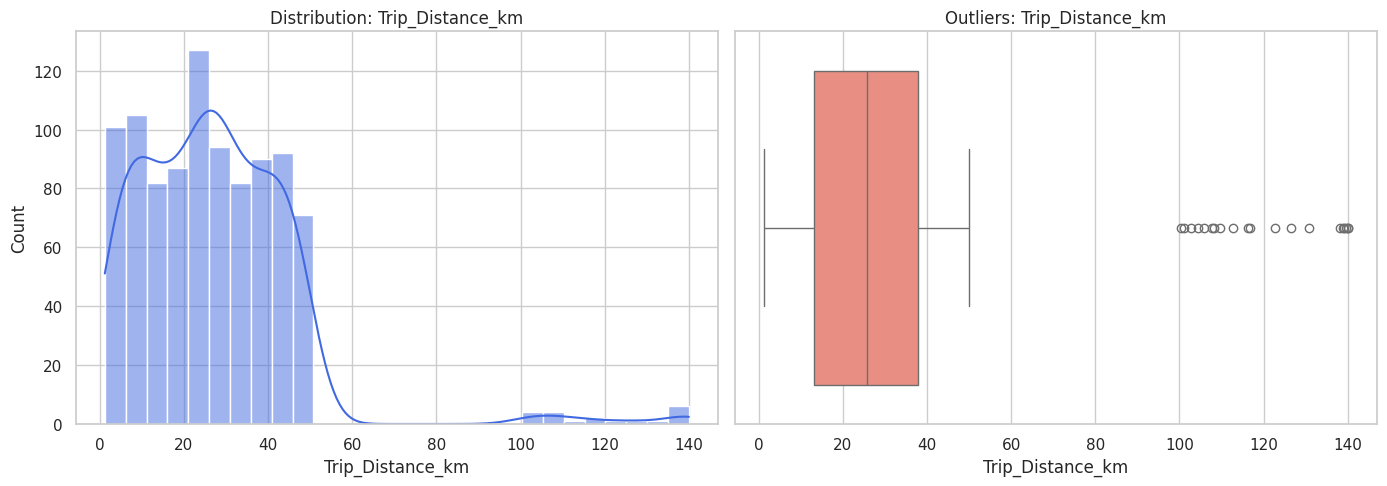

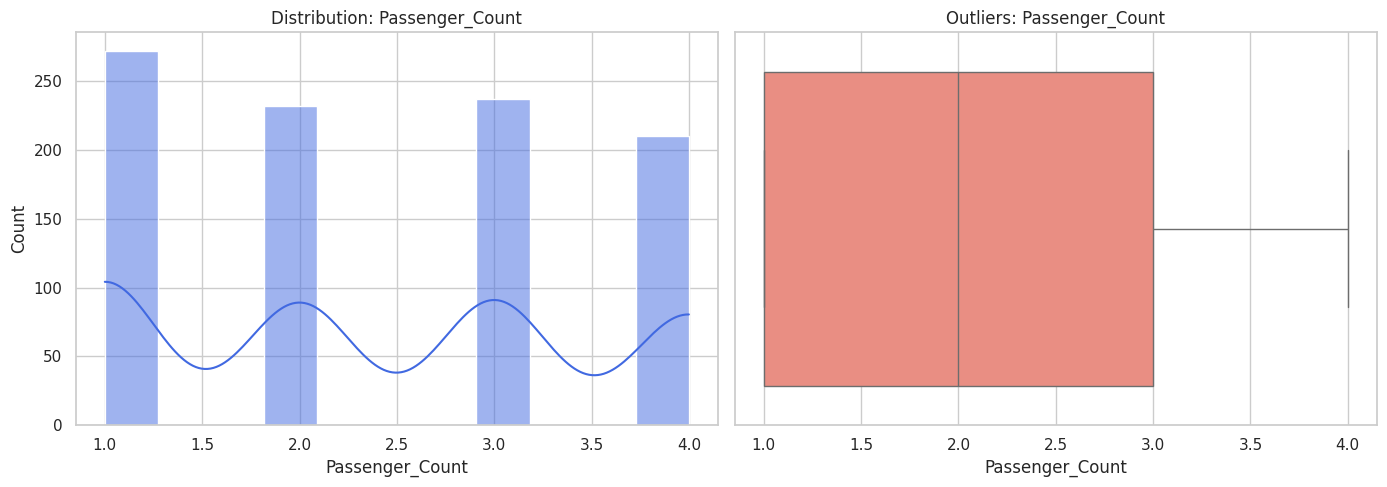

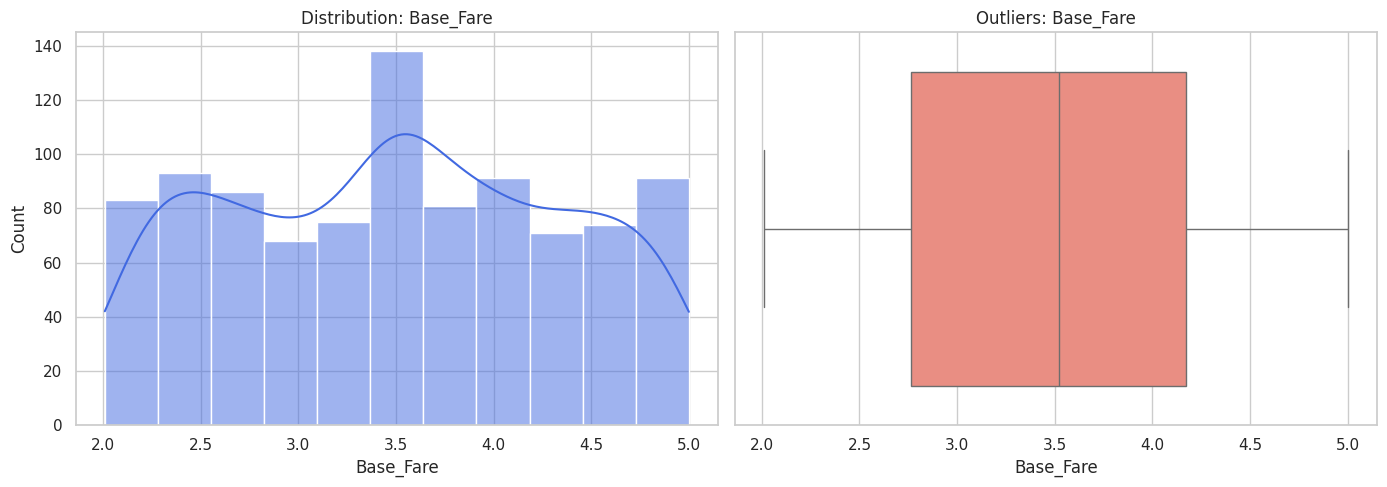

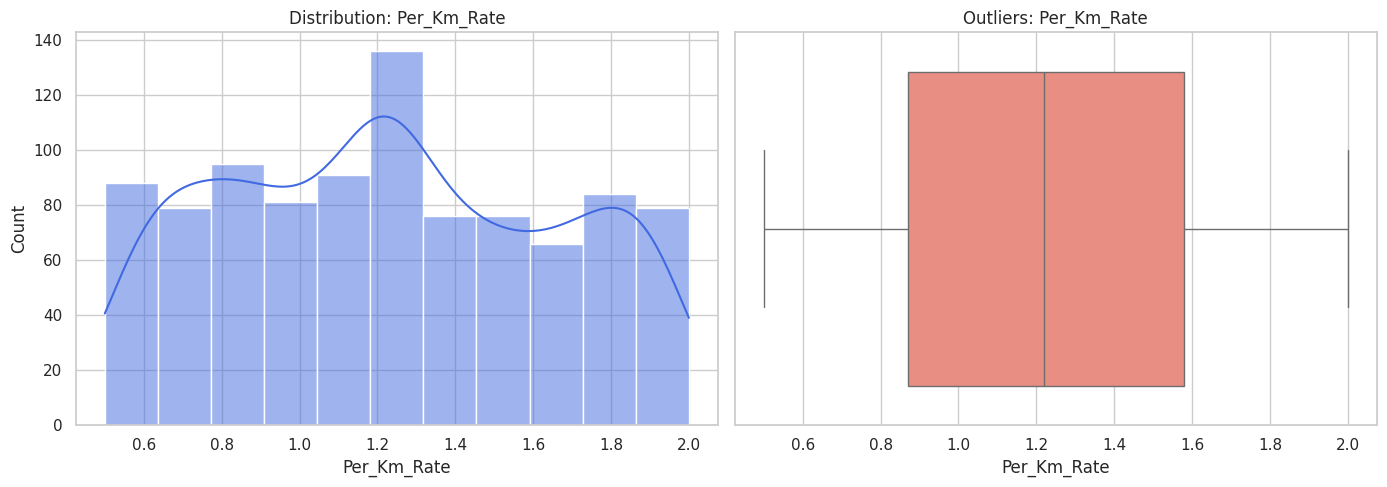

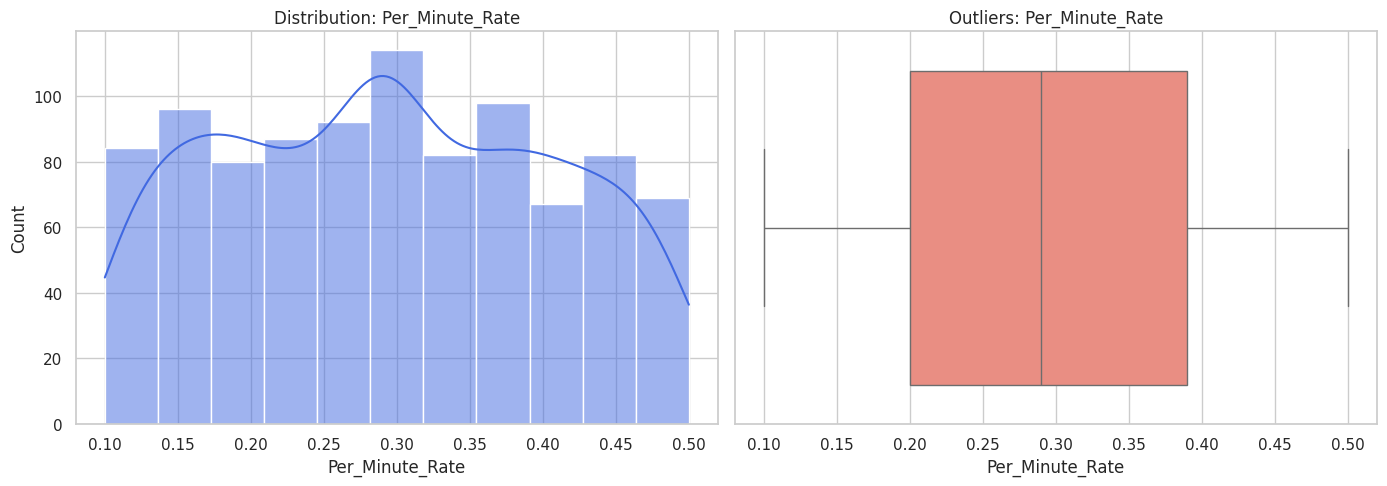

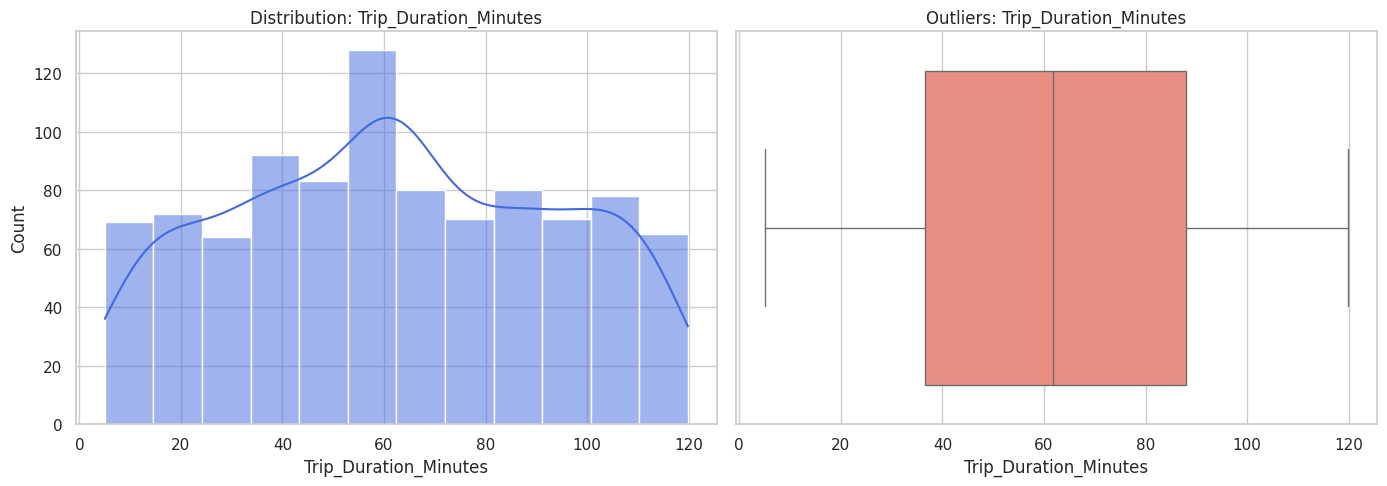

In [ ]:
viz = DataVisualizer(data=df.data,target_col='Trip_Price')
viz.plot_numerical()

In [ ]:
# Nhận xét : Cần xử lí oulier của cột 'Trip_Distance_km'
outlier_rules={'Trip_Distance_km' : "iqr"}
df.handle_outliers(outlier_rules)

📉 XỬ LÝ OUTLIER (1 cột)
   > Trip_Distance_km     | Method: IQR             -> Đã XÓA 20 dòng.
----------------------------------------------------------------------


Xử lí Scaling

In [ ]:
# --- 3. THIẾT LẬP QUY TẮC SCALING (Chuẩn hóa số) ---
df.scaler_rules = {
    "Trip_Distance_km": "standard",
    "Trip_Duration_Minutes": "standard",
    "Passenger_Count": "standard",
    "Base_Fare": "standard",
    "Per_Km_Rate": "standard",
    "Per_Minute_Rate": "standard"
}

In [ ]:
df.scale()

/tmp/ipython-input-1471689548.py:744: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[[col]] = scaler.fit_transform(df[[col]])
/tmp/ipython-input-1471689548.py:744: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[[col]] = scaler.fit_transform(df[[col]])
/tmp/ipython-input-1471689548.py:744: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

Xử lý encoding

In [ ]:
# --- 4. THIẾT LẬP QUY TẮC ENCODING (Mã hóa phân loại) ---
df.encoder_rules = {
    # Các biến định danh -> OneHot (Vì không có thứ tự)
    "Time_of_Day": "onehot",
    "Day_of_Week": "onehot",
    "Weather": "onehot",

    # Biến có thứ tự (Low < Medium < High) -> Ordinal
    "Traffic_Conditions": "ordinal"
}

In [ ]:
df.encode()

🔠 MÃ HÓA DỮ LIỆU (4 cột)
   > Time_of_Day          | Method: One-Hot -> 4 features
   > Day_of_Week          | Method: One-Hot -> 2 features
   > Traffic_Conditions   | Method: OrdinalEncoder
   > Weather              | Method: One-Hot -> 3 features
   ... Đang ghép nối 3 nhóm One-Hot...
   ✅ Hoàn tất ghép nối.
----------------------------------------------------------------------


/tmp/ipython-input-1471689548.py:838: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[[col]] = oe.fit_transform(df[[col]].astype(str))


Xử lí dữ liệu mất cân bằng

In [ ]:
df.auto_handle_imbalance(target_col='Trip_Price')

 BỎ QUA BƯỚC CÂN BẰNG DỮ LIỆU (Target: 'Trip_Price')
    Lý do: Cột 'Trip_Price' có 931 giá trị số riêng biệt.
      -> Hệ thống nhận diện đây là Numerical data.
      -> SMOTE chỉ dùng cho bài toán Categorical data.
----------------------------------------------------------------------


In [ ]:
# Lưu ngay tại thư mục hiện tại
df.save("taxi_price_processed.csv")

 ĐÃ LƯU FILE THÀNH CÔNG!
    Đường dẫn: /content/taxi_price_processed.csv
    Kích thước: 931 dòng x 17 cột


## Phần 3: Trực quan hóa và phân tích

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Optional

class DataVisualizer:
    """
    - Class trực quan hóa dữ liệu linh hoạt.
    - Khởi tạo ban đầu là bộ dữ liệu đã làm sạch từ bước trước và biến mục tiêu.
    - Cho phép người dùng chỉ định chính xác các cột cần vẽ cho từng loại biểu đồ.
    - Hỗ trợ các loại biểu đồ như plot , barplot,heatmap,...
    """

    def __init__(self, data: pd.DataFrame = None, target_col: str = None):
        self.data = data
        self.target_col = target_col

        # Cấu hình giao diện
        sns.set_theme(style="whitegrid")
        plt.rcParams['figure.figsize'] = (10, 6)
        plt.rcParams['font.size'] = 11

    def set_data(self, data: pd.DataFrame):
        self.data = data

# --- Hàm phụ trợ kiểm tra các cột trước khi dùng để vẽ biểu đồ ---
    def _validate_cols(self, cols: List[str], dtype_include=None) -> List[str]:
        """
        Hàm thông minh để chốt danh sách cột cần vẽ.
        - Nếu cols có giá trị: Kiểm tra xem cột có trong data không.
        - Nếu cols=None: Tự động lấy tất cả cột theo kiểu dữ liệu (number/object).
        """
        if self.data is None:
          return []

        # Trường hợp 1: Người dùng KHÔNG truyền cột -> Tự động lấy hết
        if cols is None:
            if dtype_include:
                valid_cols = self.data.select_dtypes(include=dtype_include).columns.tolist()
            else:
                valid_cols = self.data.columns.tolist()

            # Tự động loại bỏ target_col cho đỡ rối (trừ khi muốn vẽ nó)
            if self.target_col in valid_cols:
                valid_cols.remove(self.target_col)
            return valid_cols

        # Trường hợp 2: Người dùng CÓ truyền cột -> Kiểm tra sự tồn tại
        valid_cols = [c for c in cols if c in self.data.columns]

        # Báo cảnh báo nếu có cột bị sai tên
        missing = set(cols) - set(valid_cols)
        if missing:
            print(f" Các cột sau không tồn tại và sẽ bị bỏ qua: {missing}")

        return valid_cols


# =================================================================
# 1. VẼ PHÂN PHỐI (HISTOGRAM / BOXPLOT) - Dùng cho numeric để phát hiện outlier, kiểm tra phân phối
    def plot_numerical(self, cols: List[str] = None):
        """
        Vẽ Histogram và Boxplot cho các cột số.
        Ví dụ: viz.plot_numerical(cols=['Age', 'Salary', 'Price'])
        """
        # Chỉ lấy các cột số
        target_cols = self._validate_cols(cols, dtype_include=['number'])

        if not target_cols:
            print(" Không có cột số nào để vẽ.")
            return

        print(f" Đang vẽ biểu đồ phân phối cho: {target_cols}")
        for col in target_cols:
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))

            # Histogram
            sns.histplot(self.data[col], kde=True, ax=axes[0], color='royalblue')
            axes[0].set_title(f'Distribution: {col}')

            # Boxplot
            sns.boxplot(x=self.data[col], ax=axes[1], color='salmon')
            axes[1].set_title(f'Outliers: {col}')

            plt.tight_layout()
            plt.show()

# =================================================================
# 2. VẼ TẦN SUẤT (BAR CHART / COUNTPLOT) - Kiểm tra imbalance của dữ liệu
    def plot_categorical(self, cols: List[str] = None, top_n: int = 10):
        """
        Vẽ Countplot cho các cột phân loại.
        Ví dụ: viz.plot_categorical(cols=['City', 'Gender', 'Weather', 'Traffic'])
        """
        # Lấy cột phân loại (bao gồm cả object và category)
        target_cols = self._validate_cols(cols, dtype_include=['object', 'category'])

        if not target_cols:
            print(" Không có cột phân loại nào để vẽ.")
            return

        print(f" Đang vẽ biểu đồ tần suất cho: {target_cols}")

        # Vẽ từng cái một cho rõ (ở đây chọn vẽ từng cái cho rõ ràng)
        for col in target_cols:
            # Bỏ qua nếu quá nhiều giá trị (vẽ sẽ bị nát)
            if self.data[col].nunique() > 50:
                print(f" Bỏ qua '{col}' vì có quá nhiều giá trị unique ({self.data[col].nunique()}).")
                continue

            plt.figure(figsize=(10, 5))
            # Sắp xếp theo số lượng giảm dần
            order = self.data[col].value_counts().iloc[:top_n].index
            sns.countplot(data=self.data, y=col, palette='coolwarm', order=order)
            plt.title(f'Frequency: {col} (Top {top_n})')
            plt.show()


# =================================================================
# 3. VẼ QUAN HỆ (SCATTER / VIOLIN / HEATMAP)
    def plot_correlation(self, cols: List[str] = None):
        """
        Vẽ Heatmap tương quan.
        Ví dụ: viz.plot_correlation(cols=['Age', 'Salary', 'Score'])
        Kiểm tra mối quan hệ tuyến tính giữa các biến đầu vào
        """
        target_cols = self._validate_cols(cols, dtype_include=['number'])
        if len(target_cols) < 2:
            print(" Cần ít nhất 2 cột số để vẽ tương quan.")
            return

        plt.figure(figsize=(10, 8))
        corr = self.data[target_cols].corr()
        mask = np.triu(np.ones_like(corr, dtype=bool))
        sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='RdBu_r', center=0)
        plt.title(f"Tương quan giữa các biến: {target_cols}")
        plt.show()

    def plot_relationship_target(self, cols: List[str] = None):
        """
        Vẽ quan hệ giữa các cột chỉ định với cột Target.
        Tự động chọn Boxplot (nếu col là số) hoặc Stacked Bar (nếu col là chữ).
        """
        if not self.target_col: return
        target_cols = self._validate_cols(cols) # Lấy cả số và chữ

        for col in target_cols:
            if col == self.target_col: continue

            plt.figure(figsize=(10, 6))

            # Nếu cột là số -> Vẽ Boxplot/Violin theo Target
            if pd.api.types.is_numeric_dtype(self.data[col]):
                sns.violinplot(data=self.data, x=self.target_col, y=col, palette="muted")
                plt.title(f"Quan hệ: {col} vs {self.target_col}")

            # Nếu cột là chữ -> Vẽ Stacked Bar
            else:
                ct = pd.crosstab(self.data[col], self.data[self.target_col], normalize='index')
                ct.plot(kind='bar', stacked=True, colormap='viridis', ax=plt.gca())
                plt.title(f"Quan hệ: {col} vs {self.target_col}")
                plt.ylabel("Tỷ lệ")

            plt.show()

# =================================================================
# NHÓM 4: BIỂU ĐỒ NÂNG CAO & THỐNG KÊ (ADD-ONS)

    def plot_missing_heatmap(self):
        """
        Vẽ bản đồ vị trí dữ liệu khuyết thiếu.
        Giúp phát hiện quy luật mất mát dữ liệu.
        """
        if self.data is None: return

        # Chỉ vẽ nếu có missing data
        if self.data.isna().sum().sum() == 0:
            print("✅ Dữ liệu sạch, không có Missing Value để vẽ.")
            return

        plt.figure(figsize=(12, 6))
        # cbar=False để đỡ rối, yticklabels=False để ẩn index nếu quá dày
        sns.heatmap(self.data.isna(), cbar=False, yticklabels=False, cmap='viridis')
        plt.title("Bản đồ Dữ liệu Khuyết thiếu (Vàng = Missing)")
        plt.show()

    def plot_qq(self, col: str):
        """
        Vẽ QQ Plot để kiểm tra phân phối chuẩn (Normality Check).
        - Nếu các điểm nằm trên đường đỏ -> Phân phối chuẩn -> Dùng StandardScaler tốt.
        - Nếu bị cong -> Không chuẩn -> Nên cân nhắc log-transform hoặc MinMaxScaler.
        """
        from scipy import stats

        if self.data is None or col not in self.data.columns: return

        plt.figure(figsize=(8, 6))
        stats.probplot(self.data[col].dropna(), dist="norm", plot=plt)
        plt.title(f"QQ Plot: Kiểm tra phân phối chuẩn của '{col}'")
        plt.show()

    def plot_joint_distribution(self, col_x: str, col_y: str, kind='scatter'):
        """
        Vẽ biểu đồ kết hợp (Joint Plot): Scatter ở giữa + Histogram ở viền.
        Tham số kind: 'scatter', 'kde', 'hex' (cho dữ liệu lớn), 'reg' (hồi quy).
        """
        if self.data is None: return

        # Kiểm tra 2 cột phải là số
        if not (pd.api.types.is_numeric_dtype(self.data[col_x]) and
                pd.api.types.is_numeric_dtype(self.data[col_y])):
            print("⚠️ Joint Plot chỉ hỗ trợ 2 cột số.")
            return

        print(f" Đang vẽ Joint Plot: {col_x} vs {col_y}...")
        g = sns.jointplot(data=self.data, x=col_x, y=col_y, kind=kind,
                          color='teal', height=8)
        g.fig.suptitle(f"Joint Plot: {col_x} vs {col_y}", y=1.02)
        plt.show()

    def plot_hexbin_density(self, col_x: str, col_y: str):
        """
        Vẽ biểu đồ mật độ lục giác (Hexbin).
        Cực kỳ hữu ích cho dữ liệu lớn (Big Data) thay thế cho Scatter Plot.
        """
        if self.data is None: return

        plt.figure(figsize=(10, 8))
        plt.hexbin(self.data[col_x], self.data[col_y], gridsize=30, cmap='Blues', mincnt=1)
        plt.colorbar(label='Số lượng điểm dữ liệu')
        plt.xlabel(col_x)
        plt.ylabel(col_y)
        plt.title(f"Biểu đồ Mật độ Hexbin: {col_x} vs {col_y}")
        plt.show()
# =================================================================
# NHÓM 5: ĐÁNH GIÁ MÔ HÌNH (MODEL EVALUATION)

    def evaluate_classification(self, model, X_test, y_test):
        """Vẽ Confusion Matrix, ROC Curve, Feature Importance (Cho phân loại)."""
        from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

        # 1. Confusion Matrix
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)

        fig, ax = plt.subplots(1, 2, figsize=(16, 6))

        # Plot CM
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues', ax=ax[0], colorbar=False)
        ax[0].set_title("Confusion Matrix")

        # 2. ROC Curve (Nếu có probability)
        if hasattr(model, "predict_proba") and len(np.unique(y_test)) == 2:
            y_probs = model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_probs)
            roc_auc = auc(fpr, tpr)

            ax[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
            ax[1].plot([0, 1], [0, 1], 'k--', lw=2)
            ax[1].set_xlabel('False Positive Rate')
            ax[1].set_ylabel('True Positive Rate')
            ax[1].set_title('ROC Curve')
            ax[1].legend(loc="lower right")
        else:
            ax[1].text(0.5, 0.5, "Không hỗ trợ vẽ ROC (Multi-class hoặc không có proba)", ha='center')

        plt.show()

        # 3. Feature Importance
        self._plot_feature_importance(model, X_test.columns)

    def evaluate_regression(self, model, X_test, y_test):
        """Vẽ Actual vs Predicted và Residuals (Cho hồi quy)."""
        y_pred = model.predict(X_test)

        fig, ax = plt.subplots(1, 2, figsize=(16, 6))

        # Actual vs Predicted
        sns.scatterplot(x=y_test, y=y_pred, ax=ax[0], alpha=0.6)
        min_val, max_val = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
        ax[0].plot([min_val, max_val], [min_val, max_val], 'r--')
        ax[0].set_title("Actual vs Predicted")

        # Residuals
        residuals = y_test - y_pred
        sns.histplot(residuals, kde=True, ax=ax[1], color='purple')
        ax[1].set_title("Residuals Distribution")

        plt.show()
        self._plot_feature_importance(model, X_test.columns)

    def _plot_feature_importance(self, model, feat_names):
        """Hàm phụ trợ vẽ mức độ quan trọng của đặc trưng."""
        importances = None
        if hasattr(model, "feature_importances_"):
            importances = model.feature_importances_
        elif hasattr(model, "coef_"):
            importances = np.abs(model.coef_[0]) if model.coef_.ndim > 1 else np.abs(model.coef_)

        if importances is not None:
            df_imp = pd.DataFrame({'Feature': feat_names, 'Importance': importances})
            df_imp = df_imp.sort_values('Importance', ascending=False).head(20)

            plt.figure(figsize=(10, 6))
            sns.barplot(x='Importance', y='Feature', data=df_imp, palette='magma')
            plt.title("Feature Importance (Top 20)")
            plt.show()


# Modeling

## Class ModelTrainer

In [ ]:
# cai thu vien
!pip install optuna xgboost --quiet
import numpy as np
import pandas as pd
import optuna
import joblib
import os
import logging
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [ ]:

# -------------------------- LOGGING SETUP --------------------------
logging.basicConfig(
    filename="training.log",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)


# ======================= MODELTRAINER CLASS ==========================
class ModelTrainer:
    """
    A full-featured modeling class for Regression tasks using:
        - Polynomial Regression (Pipeline)
        - Random Forest Regressor
        - XGBoost Regressor
    Supports:
        - Optuna Hyperparameter Optimization
        - Train/Test Split
        - Model Evaluation (RMSE, MAE, R2)
        - Saving/Loading Models
        - Automatic Best Model Selection
        - Reproducibility with random seed
        - Visualization (RMSE barplot)
    """

    def __init__(self, data: pd.DataFrame, target_col: str, seed: int = 42):
        """
        Parameters
        ----------
        data : pd.DataFrame
            Dataset after EDA & preprocessing.
        target_col : str
            Column to predict.
        seed : int
            Random seed for reproducibility.
        """
        self.df = data.copy()
        self.target_col = target_col
        self.seed = seed
        self.models = {}
        self.results = []
        np.random.seed(seed)
        os.makedirs("models", exist_ok=True)
        os.makedirs("results", exist_ok=True)
        logging.info("Modeling class initialized.")

    # ---------------- STATIC METHOD EXAMPLE ----------------
    @staticmethod
    def rmse(y, y_pred):
        """Compute RMSE."""
        return np.sqrt(mean_squared_error(y, y_pred))

    # ---------------- PROPERTY EXAMPLE ----------------
    @property
    def feature_names(self):
        """Return feature columns."""
        return [c for c in self.df.columns if c != self.target_col]

    # =====================================================
    #                DATA PROCESSING
    # =====================================================
    def load_data(self):
        """Split X and y from DataFrame."""
        self.X = self.df[self.feature_names]
        self.y = self.df[self.target_col]
        logging.info(f"Data loaded with shape {self.X.shape}")

    def split_data(self, test_size=0.2):
        """Train-test split."""
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y,
            test_size=test_size,
            random_state=self.seed
        )
        logging.info(f"Data split: train {self.X_train.shape}, test {self.X_test.shape}")

    # =====================================================
    #                OPTUNA OPTIMIZATION
    # =====================================================
    def optimize_params(self, model_name: str, n_trials=30):
        """
        Optimize hyperparameters for given model using Optuna.
        model_name: 'poly', 'rf', 'xgb'
        """

        def objective(trial):

            if model_name == "poly":
                degree = trial.suggest_int("degree", 1, 4)
                alpha = trial.suggest_float("alpha", 0.0001, 10.0, log=True)

                model = Pipeline([
                    ("poly", PolynomialFeatures(degree=degree)),
                    ("scaler", StandardScaler()),
                    ("ridge", Ridge(alpha=alpha, random_state=self.seed))
                ])

            elif model_name == "rf":
                model = RandomForestRegressor(
                    n_estimators=trial.suggest_int("n_estimators", 50, 300),
                    max_depth=trial.suggest_int("max_depth", 3, 20),
                    min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
                    random_state=self.seed,
                    n_jobs=-1
                )

            elif model_name == "xgb":
                model = XGBRegressor(
                    n_estimators=trial.suggest_int("n_estimators", 50, 300),
                    max_depth=trial.suggest_int("max_depth", 3, 12),
                    learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3),
                    subsample=trial.suggest_float("subsample", 0.5, 1.0),
                    colsample_bytree=trial.suggest_float("colsample_bytree", 0.5, 1.0),
                    random_state=self.seed,
                    tree_method="hist"
                )

            model.fit(self.X_train, self.y_train)
            y_pred = model.predict(self.X_test)
            return ModelTrainer.rmse(self.y_test, y_pred)

        study = optuna.create_study(direction="minimize")
        study.optimize(objective, n_trials=n_trials)

        logging.info(f"Best params for {model_name}: {study.best_params}")

        return study.best_params

    # =====================================================
    #                     TRAIN MODEL
    # =====================================================
    def train_model(self, model_name: str, params=None):
        """Train model using best params."""

        if model_name == "poly":
            model = Pipeline([
                ("poly", PolynomialFeatures(degree=params["degree"])),
                ("scaler", StandardScaler()),
                ("ridge", Ridge(alpha=params["alpha"], random_state=self.seed))
            ])

        elif model_name == "rf":
            model = RandomForestRegressor(
                **params, random_state=self.seed, n_jobs=-1
            )

        elif model_name == "xgb":
            model = XGBRegressor(
                **params, random_state=self.seed, tree_method="hist"
            )

        logging.info(f"Training {model_name} with params: {params}")

        model.fit(self.X_train, self.y_train)
        self.models[model_name] = model

    # =====================================================
    #                     EVALUATE MODEL
    # =====================================================
    def evaluate(self, model_name: str):
        """Compute RMSE, MAE, R2 for given model."""

        model = self.models[model_name]
        y_pred = model.predict(self.X_test)

        rmse = ModelTrainer.rmse(self.y_test, y_pred)
        mae = mean_absolute_error(self.y_test, y_pred)
        r2 = r2_score(self.y_test, y_pred)

        res = {
            "model": model_name,
            "RMSE": rmse,
            "MAE": mae,
            "R2": r2
        }
        self.results.append(res)
        logging.info(f"Evaluation {model_name}: {res}")

    # =====================================================
    #                     SAVE / LOAD
    # =====================================================
    def save_model(self, model_name):
        """Save model with joblib."""
        path = f"models/{model_name}.joblib"
        joblib.dump(self.models[model_name], path)
        logging.info(f"Saved model {model_name} to {path}")

    def load_model(self, model_name, path):
        """Load a saved model."""
        model = joblib.load(path)
        self.models[model_name] = model

    # =====================================================
    #              VISUALIZATION & BEST MODEL
    # =====================================================
    def plot_results(self):
        """Barplot RMSE."""
        df = pd.DataFrame(self.results)
        plt.figure(figsize=(7, 4))
        sns.barplot(x="model", y="RMSE", data=df)
        plt.title("Model RMSE Comparison")
        plt.tight_layout()
        plt.savefig("results/rmse_comparison.png")
        plt.show()

    def best_model(self):
        df = pd.DataFrame(self.results)
        return df.sort_values("RMSE").iloc[0]["model"]

    # =====================================================
    #                FULL PIPELINE
    # =====================================================
    def run_all_models(self, trials=30):
        """
        Run optimization → train → evaluate → save → plot.
        """

        for model_name in ["poly", "rf", "xgb"]:
            print(f"🔍 Optimizing {model_name} with Optuna...")
            best_params = self.optimize_params(model_name, n_trials=trials)

            print(f"🏋 Training {model_name} ...")
            self.train_model(model_name, best_params)

            print(f"📊 Evaluating {model_name} ...")
            self.evaluate(model_name)

            self.save_model(model_name)

        self.plot_results()

        print("\n🔥 Best model:", self.best_model())


In [ ]:
model = ModelTrainer(data=dp.data, target_col="Trip_Price") # Đã sửa dp.data() thành dp.data và target_col
model.load_data()
model.split_data()
model.run_all_models(trials=30)

##

# Task
Run scaling and encoding on the `df` object, then confirm that both operations have been successfully completed.

## Run Scaling

### Subtask:
Thực hiện bước chuẩn hóa dữ liệu số (scaling) trên đối tượng `df` bằng cách gọi phương thức `df.scale()`.


**Reasoning**:
The subtask is to perform data scaling. The instruction specifies calling the `df.scale()` method. This will apply the scaling rules defined in the DataPreprocessor object to the numeric columns.

